# Network Analysis of Python Package Vulnerabilities

Análise de vulnerabilidades usando **Teoria de Redes**:

- **Temporal Analysis**: evolução, survival curves, vulnerabilidades ativas
- **Network Metrics**: grau, betweenness, eigenvector, modularidade

- Descobrir quais libs de IA devemos priorizar na correção de vulnerabilide --> Ataque de Supply Chain --> OWASP TOP 10 2025

Network Epidemics of Python/AI Dependencies (SIS + Scale-Free + Immunization)

 Aplicação direta do Capítulo 10 (Network Epidemics) para:
 - Rede de dependências de bibliotecas (Python / AI libs)
 - Modelo SIS (Susceptible–Infected–Susceptible)
 - Estratégias de imunização (random vs targeted hubs)

Conceitos:
 - Nós  = pacotes / libs
 - Arestas = dependências entre libs
 - Infecção = lib com vulnerabilidade ativa (CVE)
 - Cura    = vulnerabilidade corrigida
 - SIS: lib pode ficar vulnerável várias vezes ao longo do tempo
 - Hubs: bibliotecas com alto grau / impacto estrutural
 - Bridges: bibliotecas com alta betweenness (conectam clusters)

 Saídas principais:
 - Teste de rede scale-free (P(k), α, λ_c)
 - Dinâmica SIS (mean-field e na rede real)
 - Centralidades (degree, in_degree, out_degree, betweenness)
 - Efeito de imunização randômica vs hubs sobre a prevalência ρ_g / ρ_0
 - Heatmap de TOP CWEs por cluster de comunidade


### Imports

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import powerlaw
import seaborn as sns

from collections import Counter
from IPython.display import display
from networkx.algorithms import community

plt.rcParams["figure.figsize"] = (9, 6)
plt.rcParams["axes.grid"] = True

In [2]:
# Patch leve: scatter padronizado com halo branco (não altera o tipo de retorno)
import matplotlib.axes as _axes
if not hasattr(_axes.Axes, "_scatter_style_original"):
    _axes.Axes._scatter_style_original = _axes.Axes.scatter
    def _scatter_styled(self, *args, **kwargs):
        kwargs.setdefault('edgecolors', 'white')
        kwargs.setdefault('linewidths', 0.6)
        kwargs.setdefault('alpha', 0.85)
        return _axes.Axes._scatter_style_original(self, *args, **kwargs)
    _axes.Axes.scatter = _scatter_styled
    print('[style] scatter estilizado com halo branco aplicado (retorno PathCollection).')
else:
    print('[style] scatter estilizado já ativo.')


[style] scatter estilizado com halo branco aplicado (retorno PathCollection).


In [3]:
# Estilo global + helpers (corrige cores duplicadas e replica estilo "degree")
import matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns
from cycler import cycler

PRIMARY = "#4C78A8"   # azul referência
sns.set_theme(style="whitegrid", context="notebook")
mpl.rcParams.update({
    "axes.prop_cycle": cycler(color=sns.color_palette("colorblind")),  # séries diferentes = cores diferentes
    "axes.facecolor": "#f6f7f9",
    "figure.facecolor": "white",
    "grid.color": "#e8eaed",
    "grid.linewidth": 0.8,
    "axes.titlesize": 16, "figure.titlesize": 18,
    "axes.labelsize": 13, "font.size": 12,
    "legend.frameon": False, "lines.linewidth": 2.0,
    "xtick.color": "#333333", "ytick.color": "#333333",
})

def style_axes(ax, title=None, xlabel=None, ylabel=None):
    if title:  ax.set_title(title, fontweight="bold")
    if xlabel: ax.set_xlabel(xlabel, fontweight="bold")
    if ylabel: ax.set_ylabel(ylabel, fontweight="bold")
    for s in ("top","right"): ax.spines[s].set_visible(False)
    ax.grid(True)

# 1) Multi-séries (linhas) → paleta distinta
def plot_lines(wide, title, ylabel, out_png, smooth=3):
    import numpy as np
    if wide is None or len(wide)==0: print(f"[warn] vazio: {title}"); return
    df = wide.rolling(smooth, min_periods=1).mean() if smooth and smooth>1 else wide
    x = np.arange(len(df.index))
    fig, ax = plt.subplots(figsize=(18,7))
    for col in df.columns:
        ax.plot(x, df[col].values, label=col)
    step = max(1, len(x)//12)
    ax.set_xticks(x[::step]); ax.set_xticklabels(df.index[::step], rotation=45, ha="right")
    style_axes(ax, title, "Month", ylabel)
    ax.legend(loc="best")
    plt.tight_layout(); fig.savefig(out_png, dpi=300, bbox_inches="tight"); plt.show(); print("Saved:", out_png)

# 2) Degree-style (um tom azul, pontos com halo branco) → idêntico aos PNGs
def plot_degree_scatter(xs, ys, labels=None, title=None, xlabel=None, ylabel=None, out_png=None):
    fig, ax = plt.subplots(figsize=(16,8))
    ax.scatter(xs, ys, s=40, c=PRIMARY, alpha=0.85, edgecolors="white", linewidths=0.6)
    if labels is not None:
        for i, txt in labels.items():  # labels: {index: "nome"}
            ax.annotate(txt, (xs[i], ys[i]), xytext=(5,6), textcoords="offset points",
                        fontsize=10, bbox=dict(boxstyle="round,pad=0.25", facecolor="yellow", alpha=0.9, edgecolor="#bbb"))
    style_axes(ax, title, xlabel, ylabel)
    plt.tight_layout()
    if out_png: plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    if out_png: print("Saved:", out_png)

### Configuração de arquivos

In [4]:
EDGES_PATH    = "python_dependencies_edges.csv"
TIMELINE_PATH = "outputs/top_pypi_snyk_timeline_20221112_20251112.csv"

# libs foco (AI, mas pode adaptar)
AI_LIBS = [
    'torch','tensorflow','keras','pytorch-lightning','lightning',
    'scikit-learn','xgboost','lightgbm','catboost',
    'transformers','sentence-transformers','tokenizers',
    'langchain','langchain-core','langchain-community',
    'llama-index','llama-index-core',
    'vllm','litellm','openai','mlflow','wandb','clearml','sagemaker',
    'gradio','streamlit','opencv-python','pillow'
]
AI_SET = {p.lower() for p in AI_LIBS}

TOP_K_LABELS = 15  # quantas libs rotular nos gráficos de centralidade

### 1. Carregar CSV de arestas e construir DG_all / UG_all

In [5]:
edges = pd.read_csv(EDGES_PATH)
expected_cols = {"source", "target"}
if not expected_cols.issubset(edges.columns):
    raise ValueError(f"CSV precisa colunas {expected_cols}, mas tem: {edges.columns}")

print("Amostra de arestas:")
display(edges.head())

edges["source"] = edges["source"].astype(str)
edges["target"] = edges["target"].astype(str)

# Convenção: A -> B significa "A depende de B"
DG_all = nx.DiGraph()
DG_all.add_edges_from(edges[["source", "target"]].itertuples(index=False, name=None))
DG_all.remove_edges_from(list(nx.selfloop_edges(DG_all)))

UG_all = DG_all.to_undirected()
UG_all.remove_edges_from(list(nx.selfloop_edges(UG_all)))

print(f"DG_all: {DG_all.number_of_nodes()} nodes, {DG_all.number_of_edges()} edges")
print(f"UG_all: {UG_all.number_of_nodes()} nodes, {UG_all.number_of_edges()} edges")

# Para garantir conectividade, focamos no maior componente conexo.
if not nx.is_connected(UG_all):
    largest_cc = max(nx.connected_components(UG_all), key=len)
    UG_clean = UG_all.subgraph(largest_cc).copy()
else:
    UG_clean = UG_all.copy()

print(f"UG_clean: {UG_clean.number_of_nodes()} nodes, {UG_clean.number_of_edges()} edges")

Amostra de arestas:


,source,target
0,agno,aiohttp
1,agno,opentelemetry-exporter-otlp-proto-grpc
2,agno,typing-extensions
3,agno,mem0ai
4,agno,google-genai


DG_all: 1547 nodes, 3454 edges
UG_all: 1547 nodes, 3444 edges
UG_clean: 1541 nodes, 3440 edges


###  2. Subgrafo 1-hop das AI_LIBS 

In [6]:
ai_nodes = {n for n in UG_clean.nodes() if n.lower() in AI_SET}
ai_hop = set(ai_nodes)
for n in ai_nodes:
    ai_hop.update(UG_clean.neighbors(n))

H = UG_clean.subgraph(ai_hop).copy()
print("AI 1-hop subgraph H:", H.number_of_nodes(), "nodes,", H.number_of_edges(), "edges")

# Também vamos precisar da versão direcionada restrita a H
DG_ai = DG_all.subgraph(H.nodes()).copy()
print("DG_ai:", DG_ai.number_of_nodes(), "nodes,", DG_ai.number_of_edges(), "edges")

AI 1-hop subgraph H: 427 nodes, 1272 edges
DG_ai: 427 nodes, 1275 edges


In [7]:
# Grafo de propagação de vulnerabilidade: inverte as arestas
# Original: A -> B significa "A depende de B"
# Spread:   B -> A significa "vulnerabilidade em B pode contaminar A"
DG_ai_spread = DG_ai.reverse(copy=True)
print("DG_ai_spread:", DG_ai_spread.number_of_nodes(), "nodes,", DG_ai_spread.number_of_edges(), "edges")


DG_ai_spread: 427 nodes, 1275 edges


### 3. Carregar timeline Snyk (apenas para saber quem já teve CVE)

In [8]:
timeline = pd.read_csv(TIMELINE_PATH)
timeline.columns = [c.lower() for c in timeline.columns]

if "package" not in timeline.columns:
    raise ValueError(f"Timeline precisa ter coluna 'package'. Colunas: {timeline.columns}")

timeline["package"] = timeline["package"].astype(str).str.lower()

# tenta achar coluna de data de divulgação
date_candidates = ["disclosed_date", "disclosure_date", "published_date"]
disc_col = None
for c in date_candidates:
    if c in timeline.columns:
        disc_col = c
        break
if disc_col is None:
    raise ValueError(f"Não encontrei coluna de data de divulgação em {timeline.columns}")

timeline["disclosed_date"] = pd.to_datetime(timeline[disc_col])

print("Amostra de timeline Snyk:")
display(timeline[["package","disclosed_date"]].head())

Amostra de timeline Snyk:


,package,disclosed_date
0,urllib3,2024-06-17
1,urllib3,2025-06-18
2,urllib3,2023-10-17
3,urllib3,2023-10-15
4,urllib3,2025-06-18


### 4. Teste de Scale-Free (P(k), α) e limiar epidêmico λ_c

<k>  = 5.96
<k²> = 155.04
Exponent α ≈ 1.60%
x_min = 1.0
Comparação power_law vs lognormal: R=-15.716, p=0.000


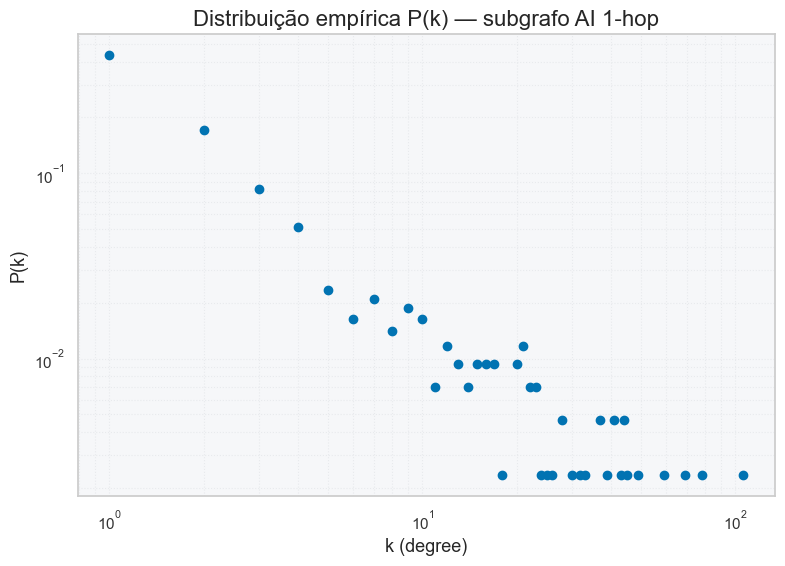

Epidemic threshold λ_c ≈ 0.0384


In [9]:
degrees = [d for _, d in H.degree()]
k_arr = np.array(degrees)

print(f"<k>  = {k_arr.mean():.2f}")
print(f"<k²> = {(k_arr**2).mean():.2f}")

# Fit power-law
k_nonzero = k_arr[k_arr > 0]
fit = powerlaw.Fit(k_nonzero, discrete=True, verbose=False)
alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
R, p = fit.distribution_compare('power_law', 'lognormal')

print(f"Exponent α ≈ {alpha:.2f}")
print(f"x_min = {xmin}")
print(f"Comparação power_law vs lognormal: R={R:.3f}, p={p:.3f}")

# P(k) empírico em log-log
cnt = Counter(degrees)
k_vals = np.array(sorted(cnt.keys()))
pk_vals = np.array([cnt[k] / len(degrees) for k in k_vals])

plt.figure()
plt.scatter(k_vals, pk_vals)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k (degree)")
plt.ylabel("P(k)")
plt.title("Distribuição empírica P(k) — subgrafo AI 1-hop")
plt.grid(True, which="both", ls=":")
plt.show()

# Limite epidêmico (aproximação heterogênea) λ_c = <k> / <k²>
lambda_c = k_arr.mean() / ((k_arr**2).mean() + 1e-9)
print(f"Epidemic threshold λ_c ≈ {lambda_c:.4f}")

## 5. SIS na rede real (H – versão nao-direcionada)

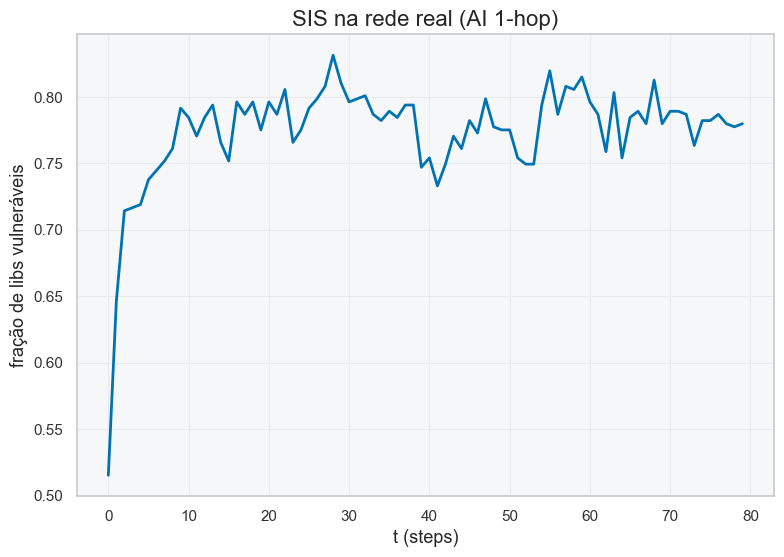

Prevalência estacionária aproximada ρ₀ ≈ 0.783


In [10]:
def simulate_SIS_on_graph(G, beta=0.25, mu=0.10, steps=80,
                          initial_infected=None, seed=42):
    """
    SIS discreto em um grafo não-direcionado:
    - G: grafo (NetworkX Graph)
    - beta: taxa de infecção por aresta
    - mu: taxa de cura
    - initial_infected: lista de nós inicialmente infectados (opcional)
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    infected = {n: False for n in nodes}

    # estado inicial: quem já teve pelo menos 1 CVE no histórico
    if initial_infected is None:
        vulnerable_pkgs = set(timeline["package"].unique())
        initial_infected = [n for n in nodes if n.lower() in vulnerable_pkgs]

    if not initial_infected:
        # fallback: escolhe 1 nó aleatório se não houver info
        initial_infected = [rng.choice(nodes)]

    for n in initial_infected:
        if n in infected:
            infected[n] = True

    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for u in nodes:
            if infected[u]:
                # tentativa de cura
                if rng.random() < mu:
                    new_state[u] = False
            else:
                # tentativa de infecção a partir de vizinhos
                for v in G.neighbors(u):
                    if infected[v] and (rng.random() < beta):
                        new_state[u] = True
                        break
        infected = new_state
        history.append(infected.copy())

    return history

beta = 0.25
mu   = 0.10

sis_hist = simulate_SIS_on_graph(H, beta=beta, mu=mu, steps=80)
infected_counts = [sum(1 for v in state.values() if v) for state in sis_hist]
frac_infected   = np.array(infected_counts) / H.number_of_nodes()

plt.figure()
plt.plot(frac_infected, linewidth=2)
plt.xlabel("t (steps)")
plt.ylabel("fração de libs vulneráveis")
plt.title("SIS na rede real (AI 1-hop)")
plt.grid(True)
plt.show()

rho0_ss = frac_infected[-20:].mean()   # prevalência estacionária ≈ ρ0
print(f"Prevalência estacionária aproximada ρ₀ ≈ {rho0_ss:.3f}")


### 7. Super-spreaders e bridges: centralidades

In [11]:
# grau (não-direcionado) no H
deg_dict = dict(H.degree())

# in/out-degree no DG_ai (orientação A->B = A depende de B)
in_dict  = dict(DG_ai.in_degree(H.nodes()))
out_dict = dict(DG_ai.out_degree(H.nodes()))

# betweenness no H
bet_dict = nx.betweenness_centrality(H, normalized=True)

centrality_df = pd.DataFrame({
    "package":   list(H.nodes()),
    "degree":    [deg_dict[n] for n in H.nodes()],
    "in_degree": [in_dict.get(n, 0) for n in H.nodes()],
    "out_degree":[out_dict.get(n, 0) for n in H.nodes()],
    "betweenness":[bet_dict[n] for n in H.nodes()],
})
centrality_df["is_ai"] = centrality_df["package"].str.lower().isin(AI_SET)

print("\nTop 15 hubs (degree):")
display(centrality_df.sort_values("degree", ascending=False).head(15))

print("\nTop 15 bridges (betweenness):")
display(centrality_df.sort_values("betweenness", ascending=False).head(15))


Top 15 hubs (degree):


,package,degree,in_degree,out_degree,betweenness,is_ai
136,transformers,106,8,99,0.263782,True
370,sagemaker,78,1,77,0.168927,True
218,vllm,69,1,69,0.132432,True
335,feast,59,0,59,0.055090,False
140,litellm,49,3,46,0.076706,True
311,mlflow,45,2,43,0.108352,True
91,open-webui,44,0,44,0.047250,False
225,pillow,44,22,22,0.086185,True
36,scikit-learn,43,10,33,0.085279,True
20,agno,41,0,41,0.021743,False



Top 15 bridges (betweenness):


,package,degree,in_degree,out_degree,betweenness,is_ai
136,transformers,106,8,99,0.263782,True
370,sagemaker,78,1,77,0.168927,True
218,vllm,69,1,69,0.132432,True
311,mlflow,45,2,43,0.108352,True
347,torch,37,11,26,0.087987,True
225,pillow,44,22,22,0.086185,True
36,scikit-learn,43,10,33,0.085279,True
140,litellm,49,3,46,0.076706,True
164,langchain,24,4,20,0.066556,True
6,llama-index-core,30,2,28,0.055096,True


### 7.0 Comunidades (clusters) no grafo H

In [12]:
comms = list(community.greedy_modularity_communities(H))
pkg_to_cluster = {}
for i, cset in enumerate(comms, start=1):
    for n in cset:
        pkg_to_cluster[n] = i   # Cluster 1, 2, 3...

centrality_df["cluster"] = centrality_df["package"].map(pkg_to_cluster).fillna(0).astype(int)

# coluna auxiliar lower-case para joins
centrality_df["package_l"] = centrality_df["package"].str.lower()

### 7.1 Gráfico: distribuição de in-degree (com labels Top K)

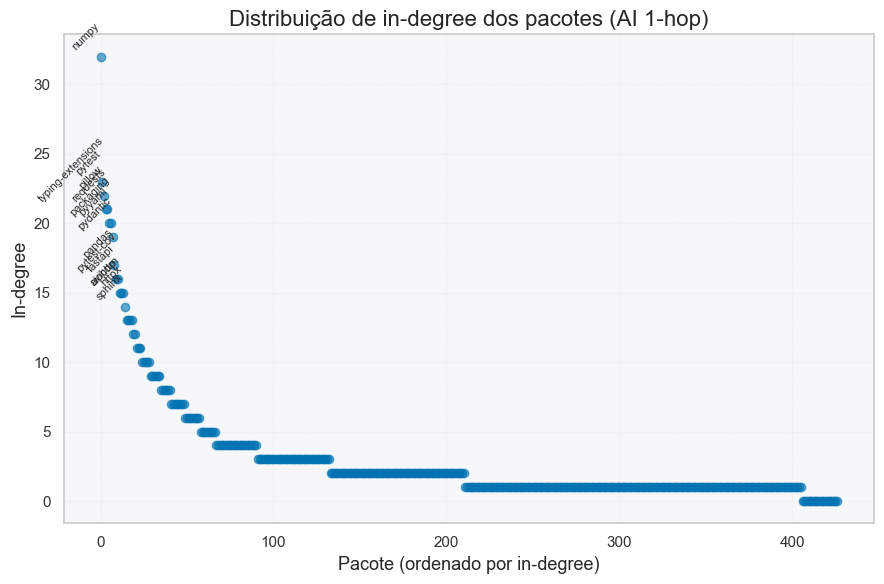

In [13]:
centrality_sorted_in = centrality_df.sort_values("in_degree", ascending=False).reset_index(drop=True)

plt.figure()
plt.scatter(range(len(centrality_sorted_in)), centrality_sorted_in["in_degree"], alpha=0.6)
plt.xlabel("Pacote (ordenado por in-degree)")
plt.ylabel("In-degree")
plt.title("Distribuição de in-degree dos pacotes (AI 1-hop)")
plt.grid(True, ls=":")

for idx, row in centrality_sorted_in.head(TOP_K_LABELS).iterrows():
    plt.text(
        idx,
        row["in_degree"] + 0.5,
        row["package"],
        fontsize=8,
        rotation=45,
        ha="right"
    )

plt.tight_layout()
plt.show()

### 7.2 Gráfico: distribuição de out-degree (com labels Top K)


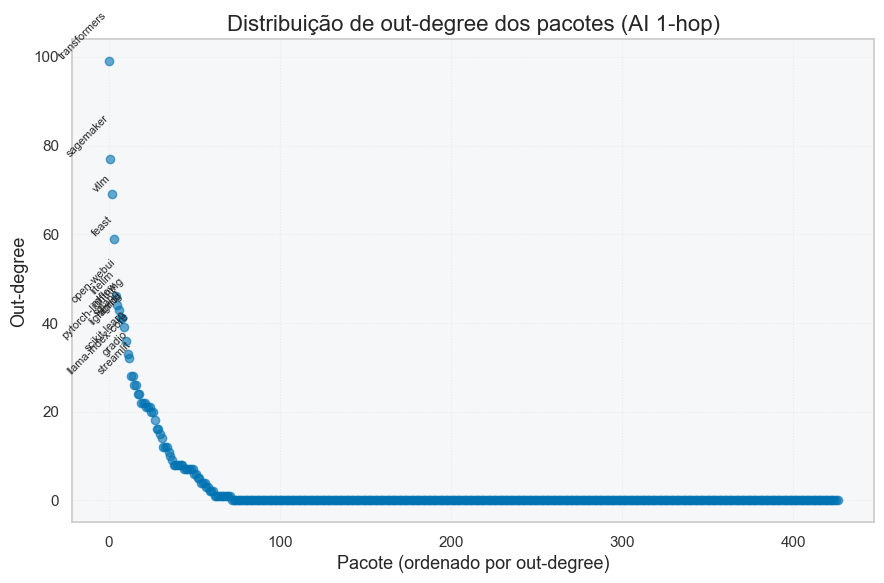

In [14]:
centrality_sorted_out = centrality_df.sort_values("out_degree", ascending=False).reset_index(drop=True)

plt.figure()
plt.scatter(range(len(centrality_sorted_out)), centrality_sorted_out["out_degree"], alpha=0.6)
plt.xlabel("Pacote (ordenado por out-degree)")
plt.ylabel("Out-degree")
plt.title("Distribuição de out-degree dos pacotes (AI 1-hop)")
plt.grid(True, ls=":")

for idx, row in centrality_sorted_out.head(TOP_K_LABELS).iterrows():
    plt.text(
        idx,
        row["out_degree"] + 0.5,
        row["package"],
        fontsize=8,
        rotation=45,
        ha="right"
    )

plt.tight_layout()
plt.show()


###  7.3 Gráfico: degree vs betweenness (hubs x bridges, com labels Top K betweenness)

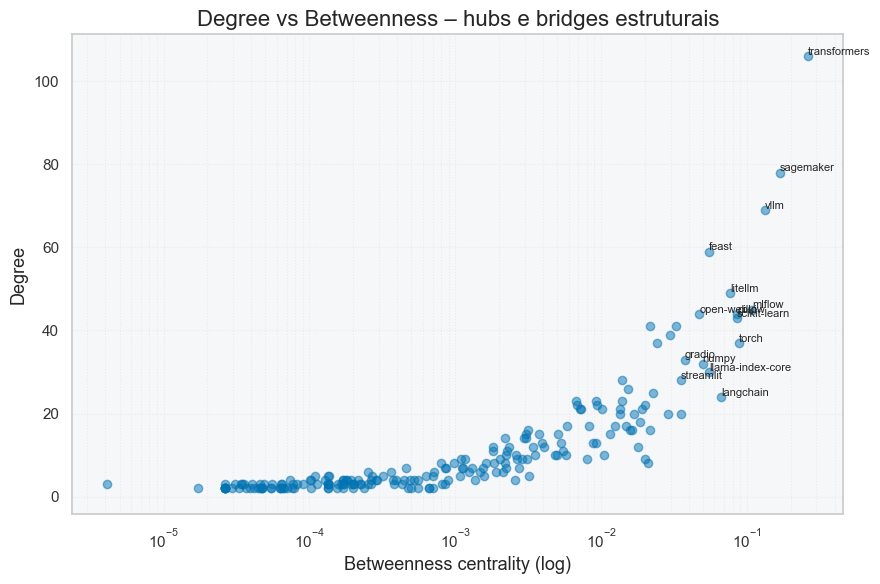

In [15]:
plt.figure()
plt.scatter(centrality_df["betweenness"], centrality_df["degree"], alpha=0.5)
plt.xscale("log")
plt.xlabel("Betweenness centrality (log)")
plt.ylabel("Degree")
plt.title("Degree vs Betweenness – hubs e bridges estruturais")
plt.grid(True, which="both", ls=":")

for _, row in centrality_df.sort_values("betweenness", ascending=False).head(TOP_K_LABELS).iterrows():
    plt.text(
        row["betweenness"],
        row["degree"] + 0.3,
        row["package"],
        fontsize=8
    )

plt.tight_layout()
plt.show()


###  8. Estratégias de imunização (random vs hubs) – ρ_g / ρ_0


In [16]:
def immunize_and_run_SIS_supply_chain(DG_spread, beta, mu, steps, immunized_nodes, seed=123):
    """
    SIS dirigido em grafo de supply chain (DG_spread):
    - vulnerabilidade flui ao longo de u -> v (dependency -> dependent)
    - 'immunized_nodes' nunca podem ficar infectados nem contaminar outros
    """
    rng = np.random.default_rng(seed)
    nodes = list(DG_spread.nodes())
    immunized_set = set(immunized_nodes)

    infected = {n: False for n in nodes}

    # estado inicial: infecta apenas nós NÃO imunizados que já tiveram CVE
    vulnerable_pkgs = set(timeline["package"].unique())
    init_candidates = [n for n in nodes
                       if (n not in immunized_set) and (n.lower() in vulnerable_pkgs)]

    if not init_candidates:
        init_candidates = [n for n in nodes if n not in immunized_set]
    if not init_candidates:
        init_candidates = [rng.choice(nodes)]

    for n in init_candidates:
        infected[n] = True

    history = []
    for _ in range(steps):
        new_state = infected.copy()

        for u in nodes:
            # nó imunizado nunca infecta nem permanece infectado
            if u in immunized_set:
                new_state[u] = False
                continue

            if infected[u]:
                # cura
                if rng.random() < mu:
                    new_state[u] = False
            else:
                # INFECTORES de u: predecessores em DG_spread (v -> u)
                for v in DG_spread.predecessors(u):
                    if (v not in immunized_set) and infected[v] and (rng.random() < beta):
                        new_state[u] = True
                        break

        infected = new_state
        history.append(infected.copy())

    infected_counts = [sum(1 for v in st.values() if v) for st in history]
    frac = np.array(infected_counts) / len(nodes)
    return frac


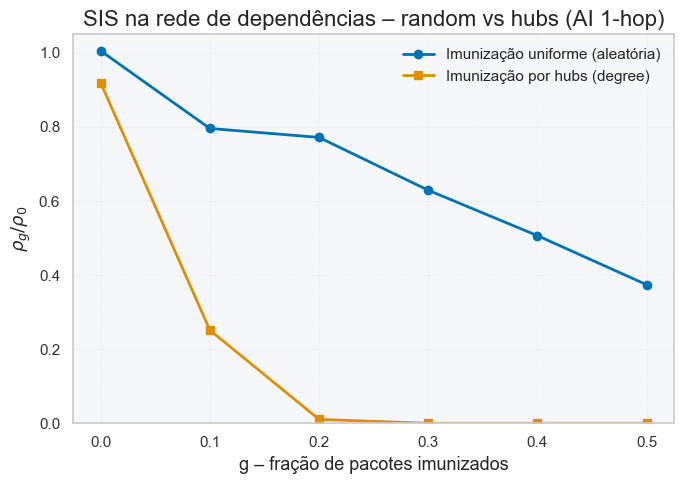

In [17]:
def immunize_and_run_SIS(G, beta, mu, steps, immunized_nodes, seed=123):
    """
    Roda SIS na rede G, mas impedindo que 'immunized_nodes' sejam infectados.
    """
    rng = np.random.default_rng(seed)
    nodes = list(G.nodes())
    immunized_set = set(immunized_nodes)

    infected = {n: False for n in nodes}

    # estado inicial: infecta apenas nós NÃO imunizados que já tiveram CVE
    vulnerable_pkgs = set(timeline["package"].unique())
    init_candidates = [n for n in nodes
                       if (n not in immunized_set) and (n.lower() in vulnerable_pkgs)]

    if not init_candidates:
        init_candidates = [n for n in nodes if n not in immunized_set]
    if not init_candidates:
        init_candidates = [rng.choice(nodes)]

    for n in init_candidates:
        infected[n] = True

    history = []
    for _ in range(steps):
        new_state = infected.copy()
        for u in nodes:
            if u in immunized_set:
                new_state[u] = False   # nunca infecta
                continue

            if infected[u]:
                if rng.random() < mu:
                    new_state[u] = False
            else:
                for v in G.neighbors(u):
                    if infected[v] and (rng.random() < beta):
                        new_state[u] = True
                        break
        infected = new_state
        history.append(infected.copy())

    infected_counts = [sum(1 for v in st.values() if v) for st in history]
    frac = np.array(infected_counts) / len(nodes)
    return frac

# Fração baseline ρ₀ (já calculada: rho0_ss)
rho0 = rho0_ss

g_values = np.linspace(0.0, 0.5, 6)   # 0%,10%,...,50% dos nós imunizados
rho_uniform = []
rho_target  = []

nodes_list = list(H.nodes())
N = len(nodes_list)
rng_global = np.random.default_rng(2025)

# ordenar por grau para imunização targeted
deg_sorted = sorted(deg_dict.items(), key=lambda x: x[1], reverse=True)
ordered_by_degree = [n for n, d in deg_sorted]

for g in g_values:
    k = max(1, int(N * g))

    # imunização uniform (aleatória)
    imm_uniform = set(rng_global.choice(nodes_list, size=k, replace=False))

    # imunização targeted (top k por degree)
    imm_target = set(ordered_by_degree[:k])

    # roda SIS para cada cenário
    frac_u = immunize_and_run_SIS(H, beta, mu, steps=80,
                                  immunized_nodes=imm_uniform, seed=10)
    frac_t = immunize_and_run_SIS(H, beta, mu, steps=80,
                                  immunized_nodes=imm_target, seed=20)

    rho_u = frac_u[-20:].mean()
    rho_t = frac_t[-20:].mean()

    rho_uniform.append(rho_u / rho0)
    rho_target.append(rho_t / rho0)

# Plot tipo Fig. 2 (ρ_g / ρ_0 vs g)

plt.figure(figsize=(7,5))
plt.plot(g_values, rho_uniform, "o-", label="Imunização uniforme (aleatória)")
plt.plot(g_values, rho_target,  "s-", label="Imunização por hubs (degree)")
plt.xlabel("g – fração de pacotes imunizados")
plt.ylabel(r"$\rho_g / \rho_0$")
plt.ylim(0, 1.05)
plt.grid(True, ls=":")
plt.legend()
plt.title("SIS na rede de dependências – random vs hubs (AI 1-hop)")
plt.tight_layout()
plt.show()


###  9. Relação Cluster x CWE (Heatmap)


Usando coluna de CWE: cwes
Amostra timeline_cwe:


,package,cluster,CWE,disclosed_date
0,urllib3,3.0,CWE-669,2024-06-17
1,urllib3,3.0,CWE-601,2025-06-18
2,urllib3,3.0,CWE-200,2023-10-17
3,urllib3,3.0,CWE-601,2023-10-15
4,urllib3,3.0,CWE-601,2025-06-18


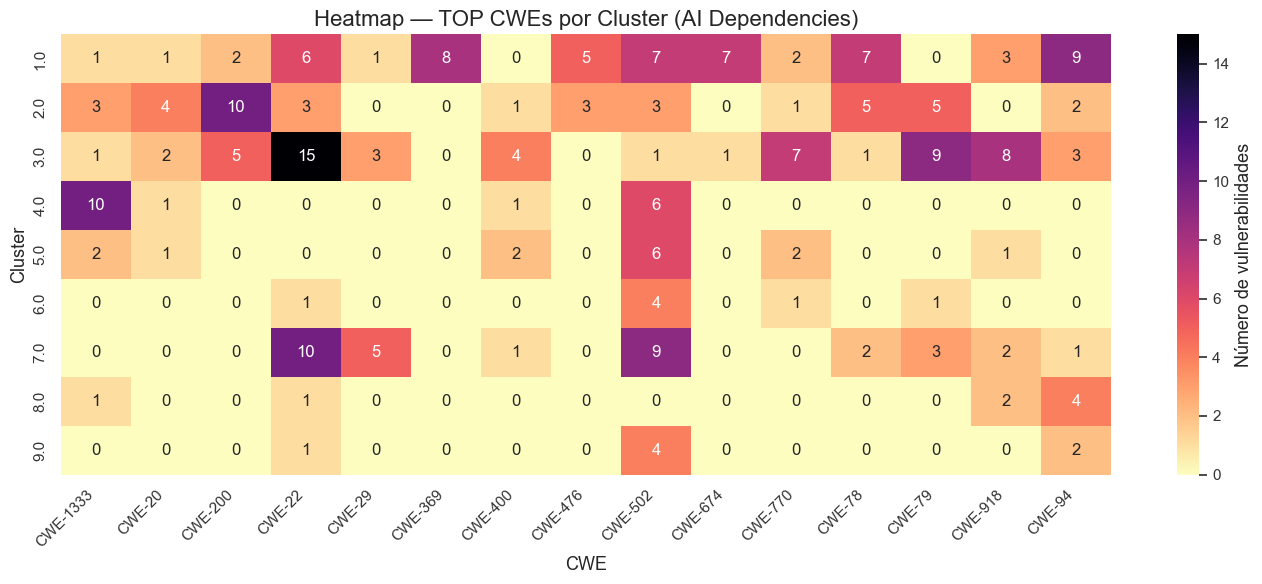

In [18]:
# Descobrir coluna de CWE automaticamente
cwe_cols = [c for c in timeline.columns if "cwe" in c.lower()]
if not cwe_cols:
    raise ValueError(f"Não encontrei coluna de CWE em: {timeline.columns}")
CWE_COL = cwe_cols[0]
print("Usando coluna de CWE:", CWE_COL)

timeline["package_l"] = timeline["package"].str.lower()

# map package_l -> cluster (0 = fora de H)
pkgcluster_map = dict(zip(centrality_df["package_l"], centrality_df["cluster"]))

timeline_cwe = timeline.copy()
timeline_cwe["cluster"] = timeline_cwe["package_l"].map(pkgcluster_map)

# filtra só entradas com cluster definido e CWE não nulo
timeline_cwe = timeline_cwe[
    timeline_cwe["cluster"].notna() & timeline_cwe[CWE_COL].notna()
].copy()

timeline_cwe.rename(columns={CWE_COL: "CWE"}, inplace=True)

print("Amostra timeline_cwe:")
display(timeline_cwe[["package","cluster","CWE","disclosed_date"]].head())

# contagem de CWE por cluster
cluster_cwe_counts = (
    timeline_cwe
    .groupby(["cluster", "CWE"])
    .size()
    .reset_index(name="count")
)

TOP_N = 15  # número de CWEs para mostrar

top_cwes = (
    cluster_cwe_counts
    .groupby("CWE")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(TOP_N)
    .index
)

filtered = cluster_cwe_counts[cluster_cwe_counts["CWE"].isin(top_cwes)]

heat_df = (
    filtered
    .pivot(index="cluster", columns="CWE", values="count")
    .fillna(0)
)

plt.figure(figsize=(14, 6))
sns.heatmap(
    heat_df,
    annot=True,
    fmt=".0f",
    cmap="magma_r",
    cbar_kws={"label": "Número de vulnerabilidades"}
)
plt.title("Heatmap — TOP CWEs por Cluster (AI Dependencies)")
plt.xlabel("CWE")
plt.ylabel("Cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


### 10.0 Desenhar árvore

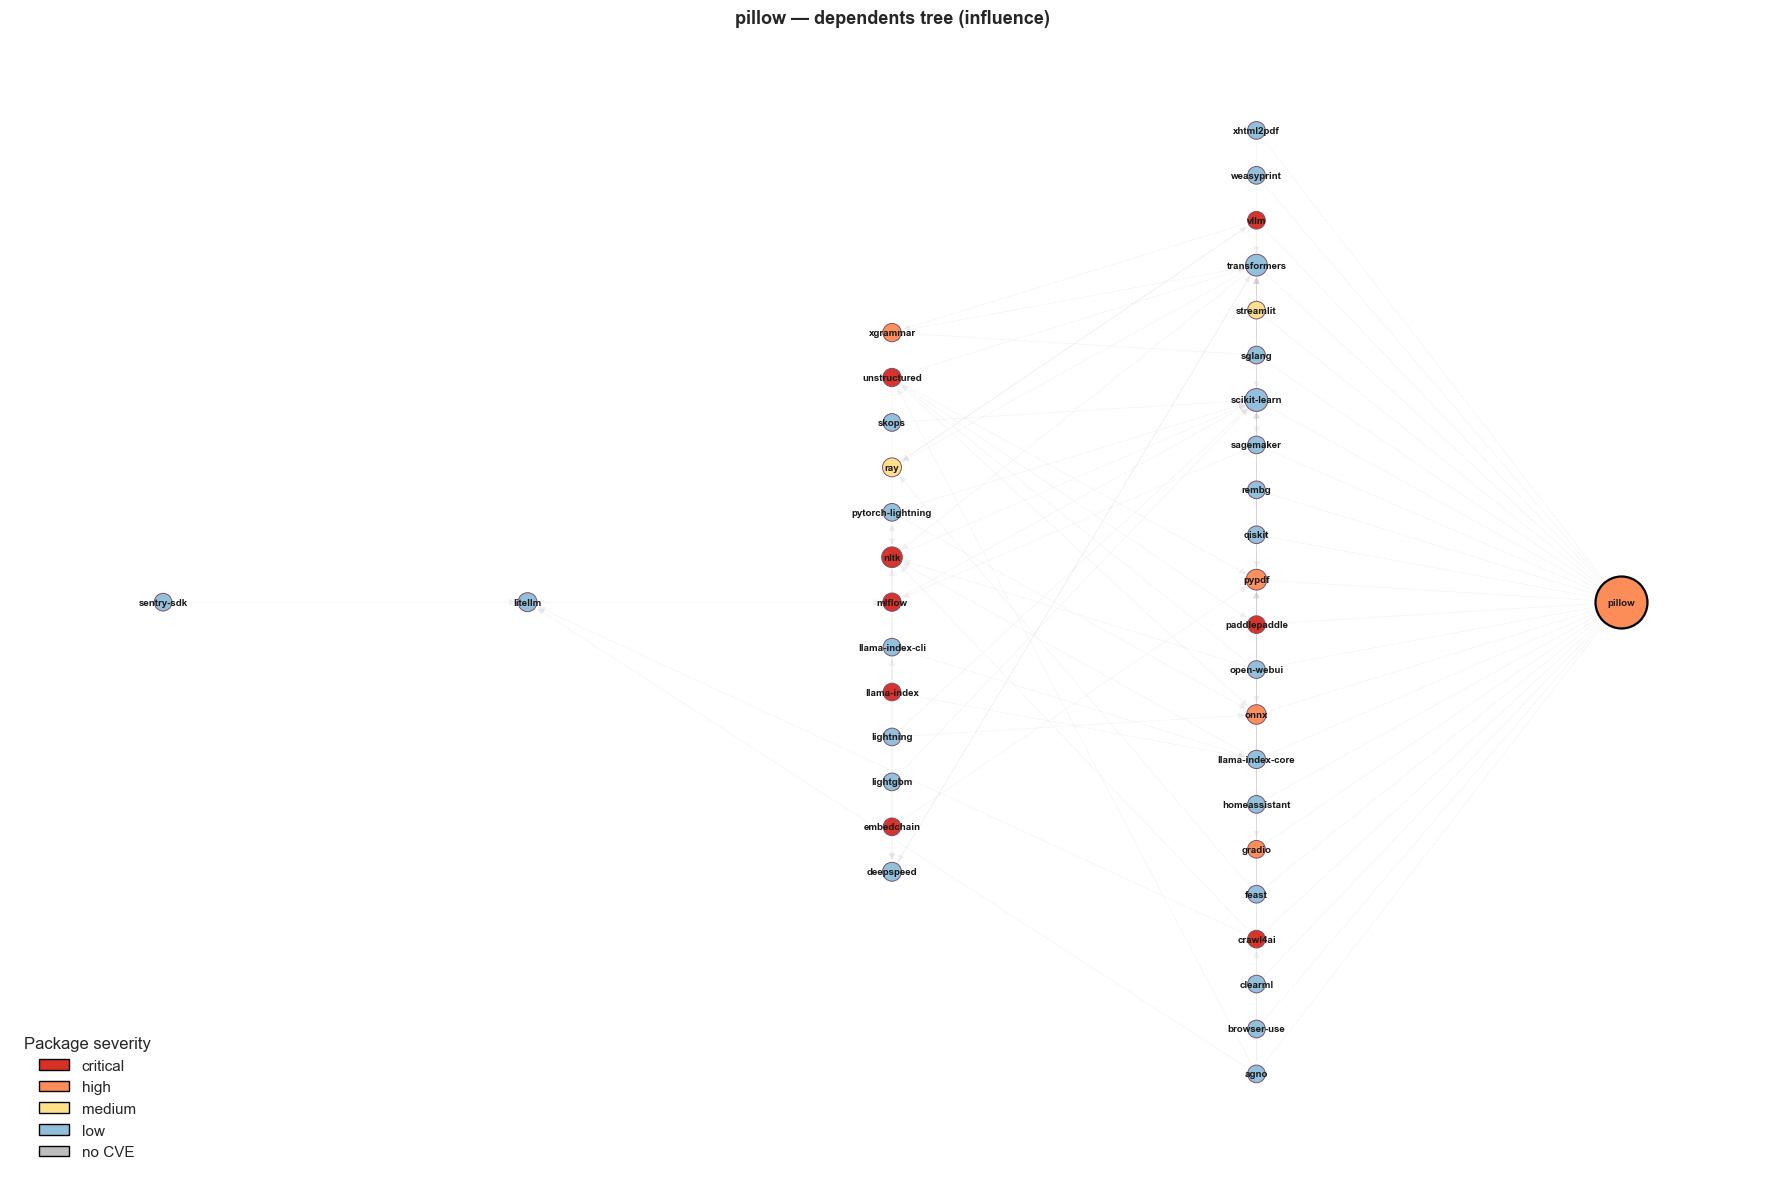

Saved outputs/plots/tree_dependents_pillow.png


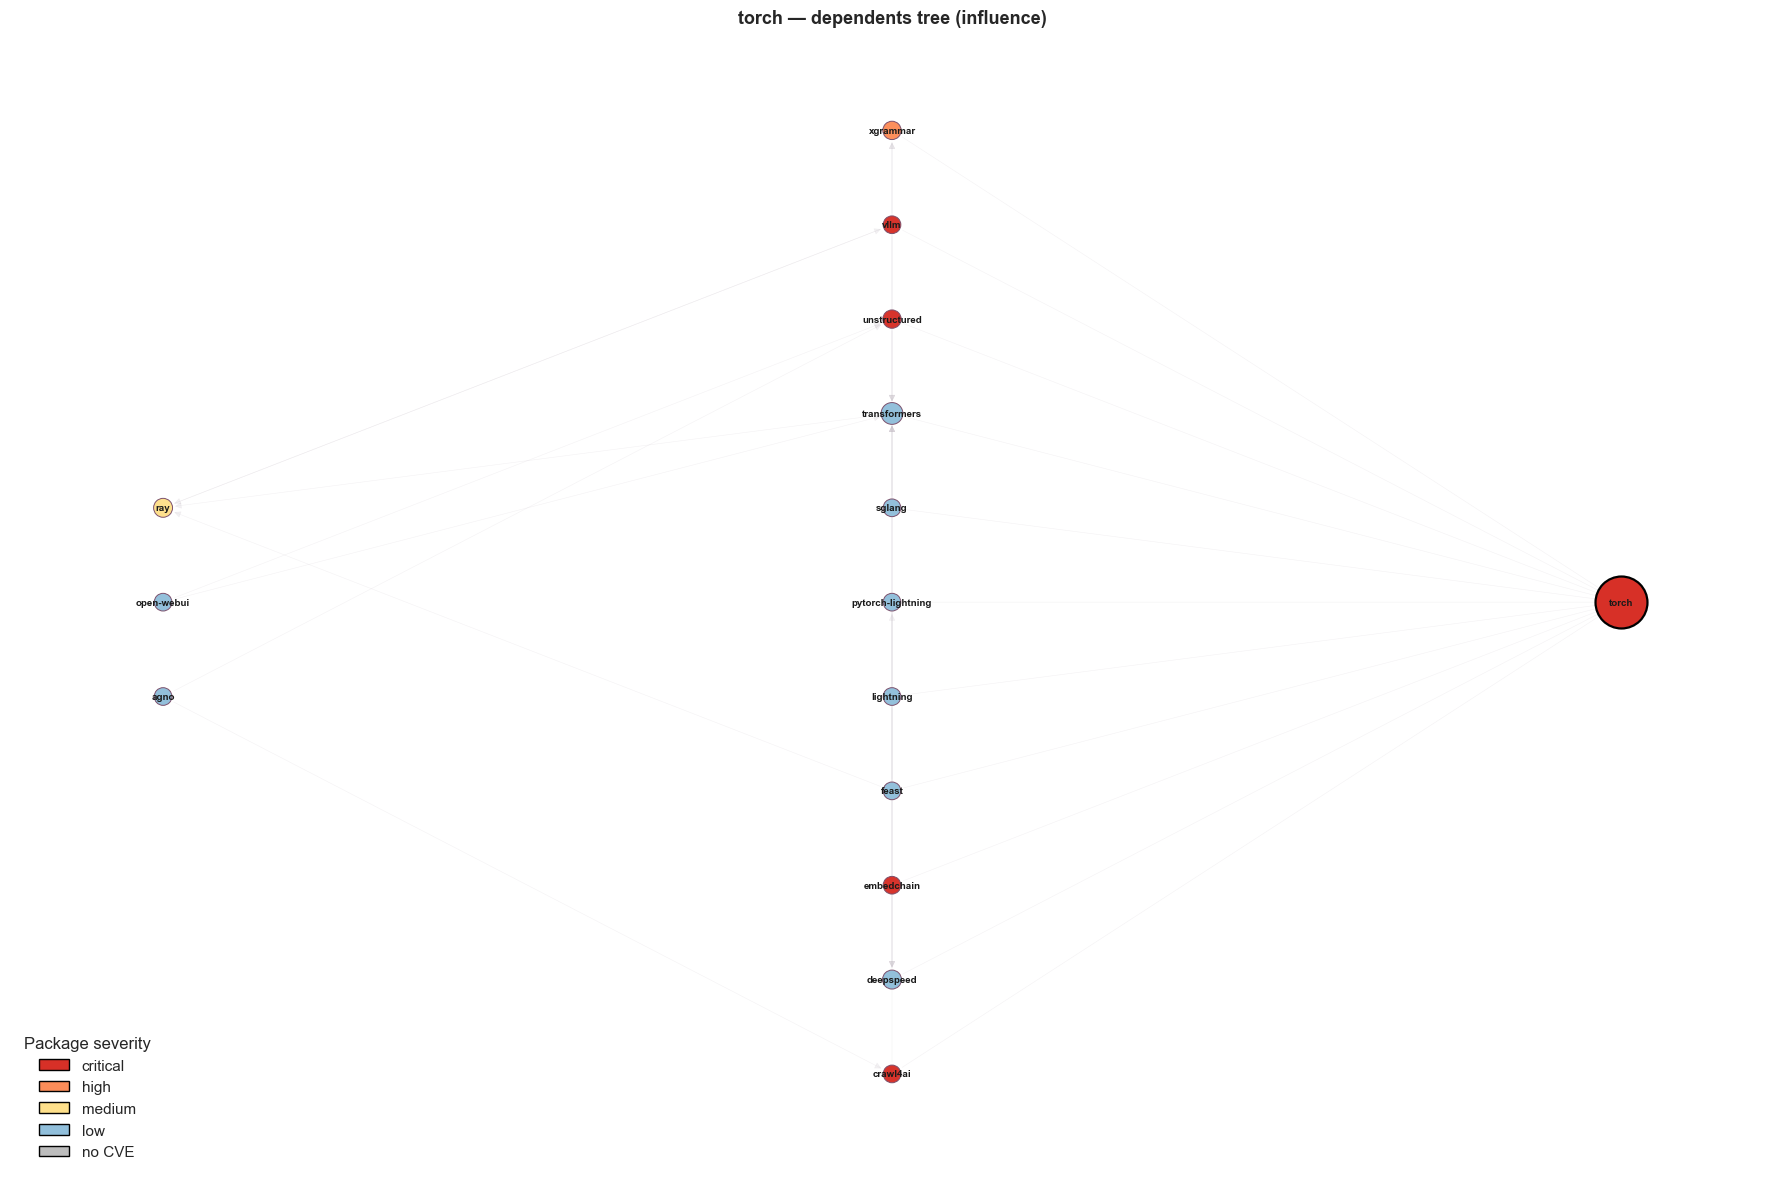

Saved outputs/plots/tree_dependents_torch.png


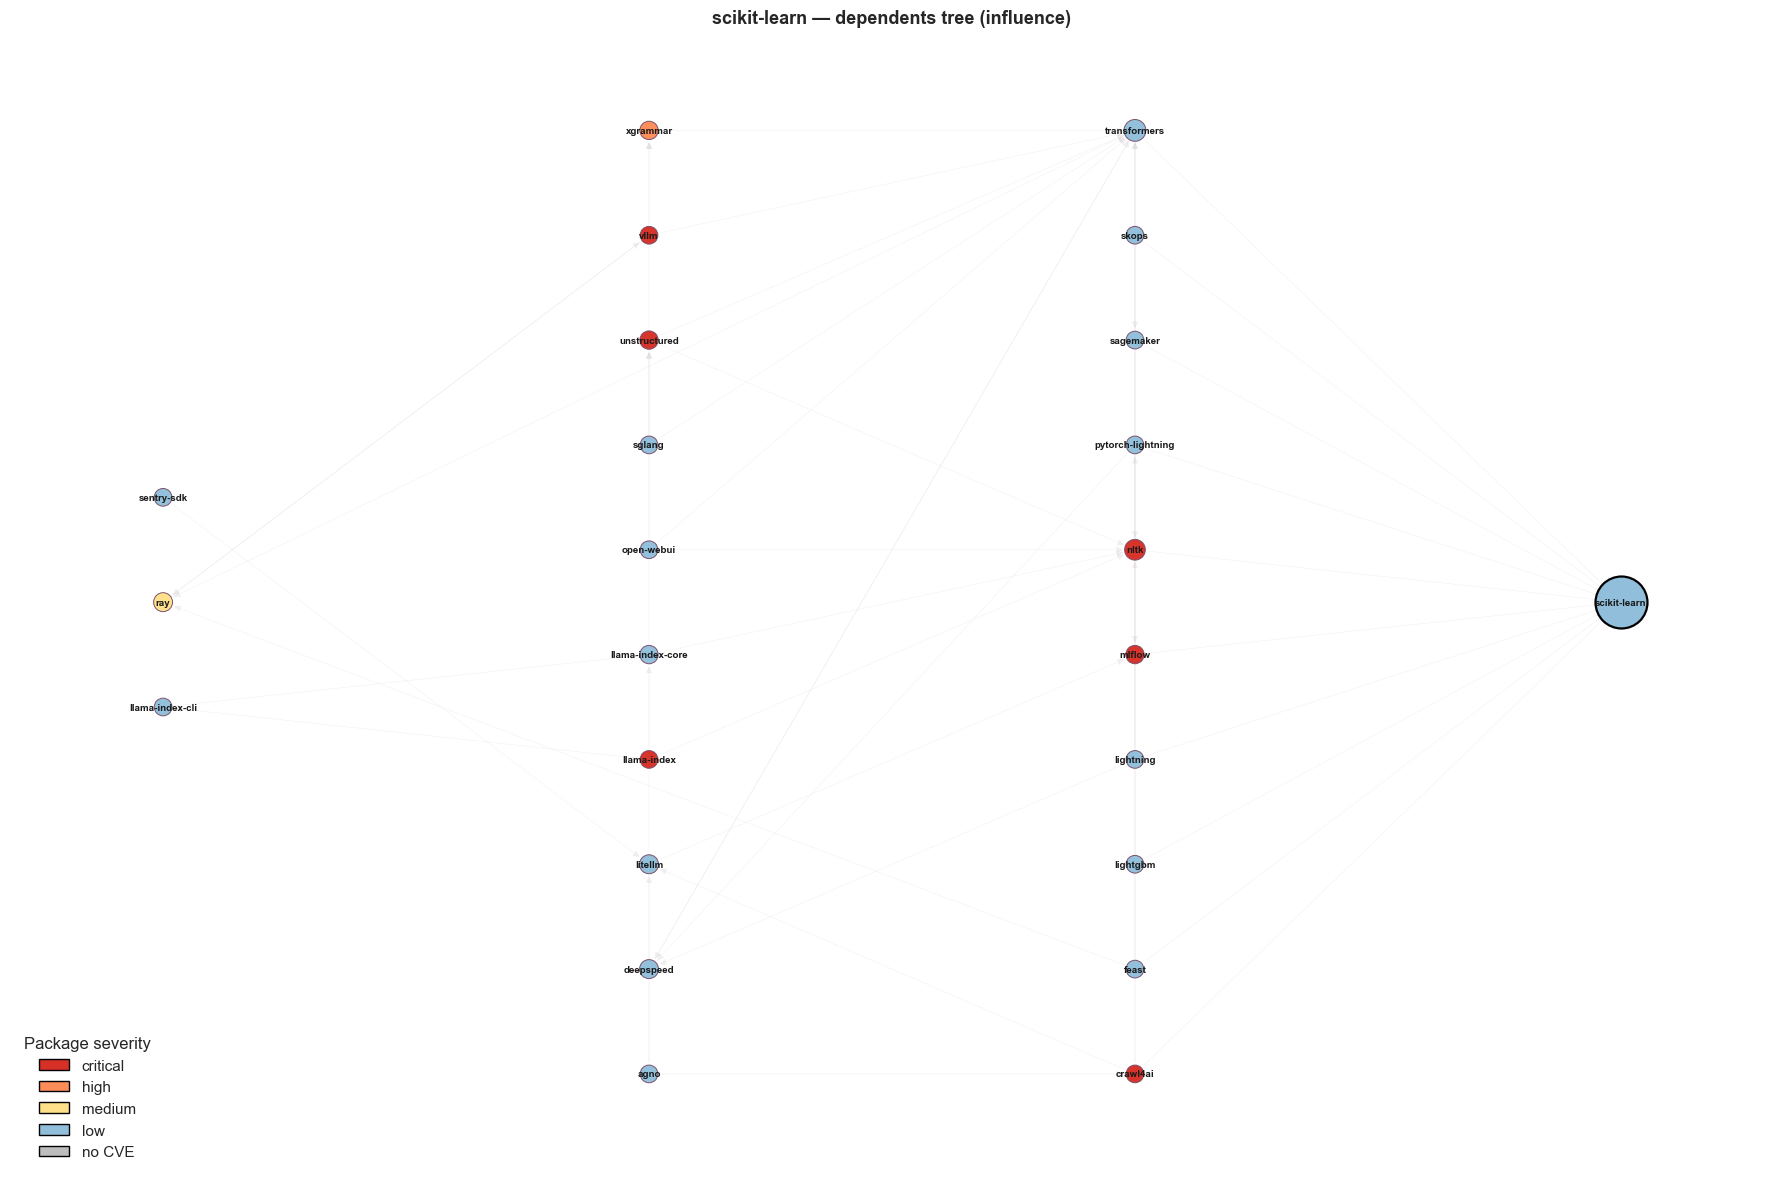

Saved outputs/plots/tree_dependents_scikit-learn.png


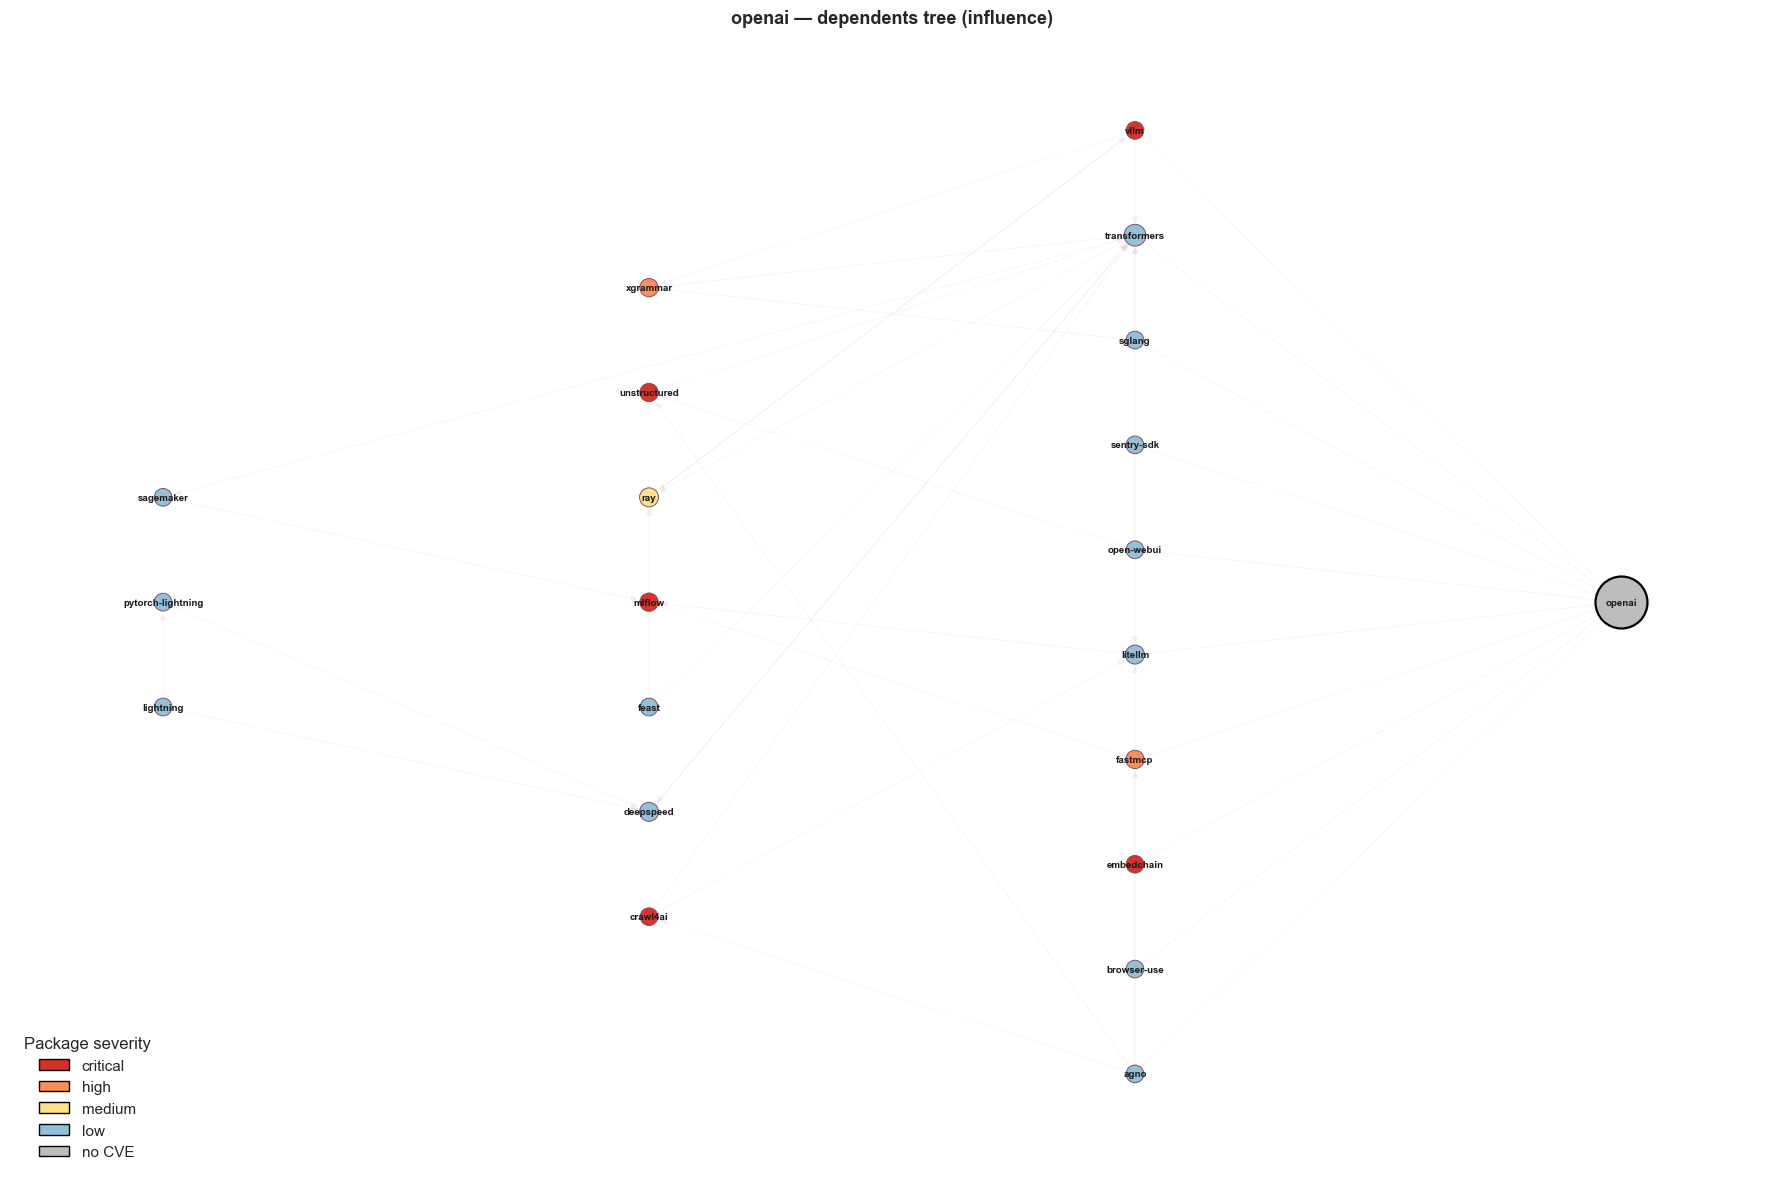

Saved outputs/plots/tree_dependents_openai.png


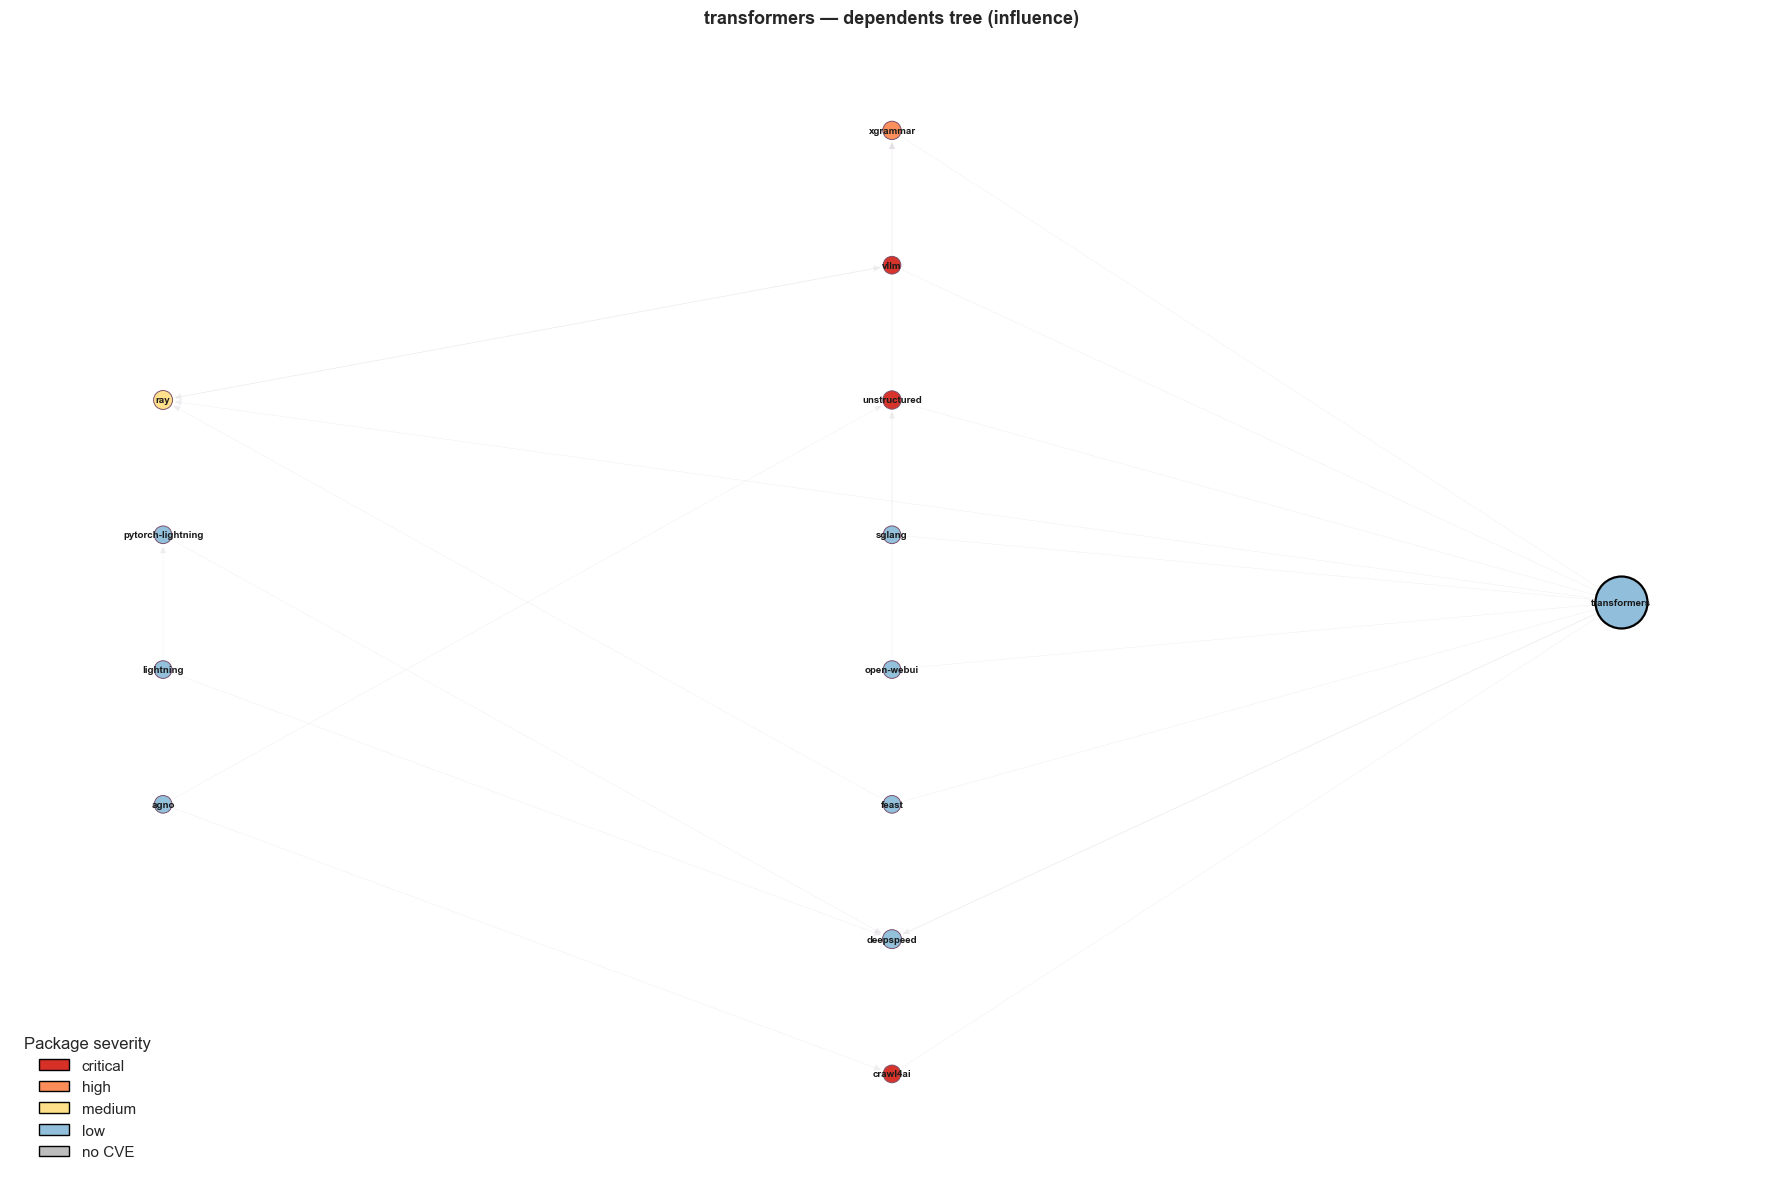

Saved outputs/plots/tree_dependents_transformers.png


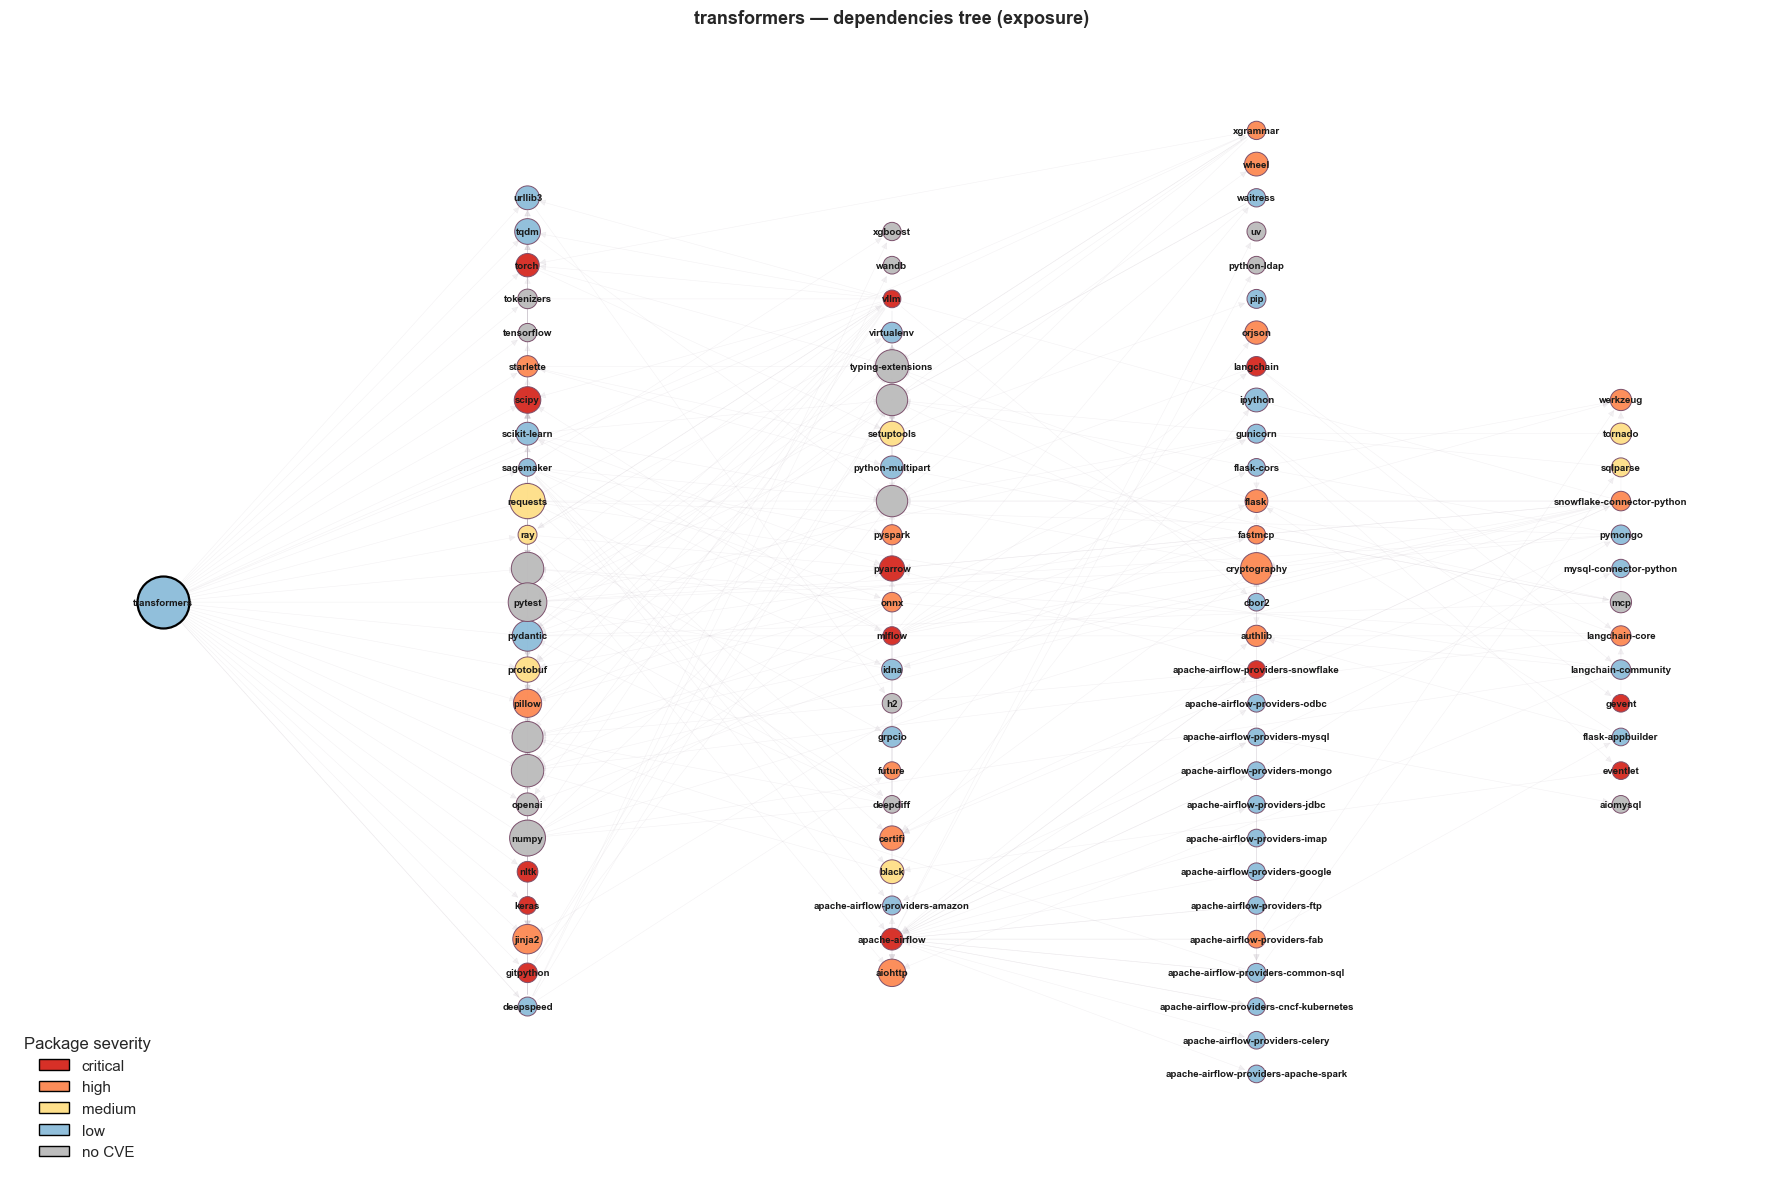

Saved outputs/plots/tree_dependencies_transformers.png


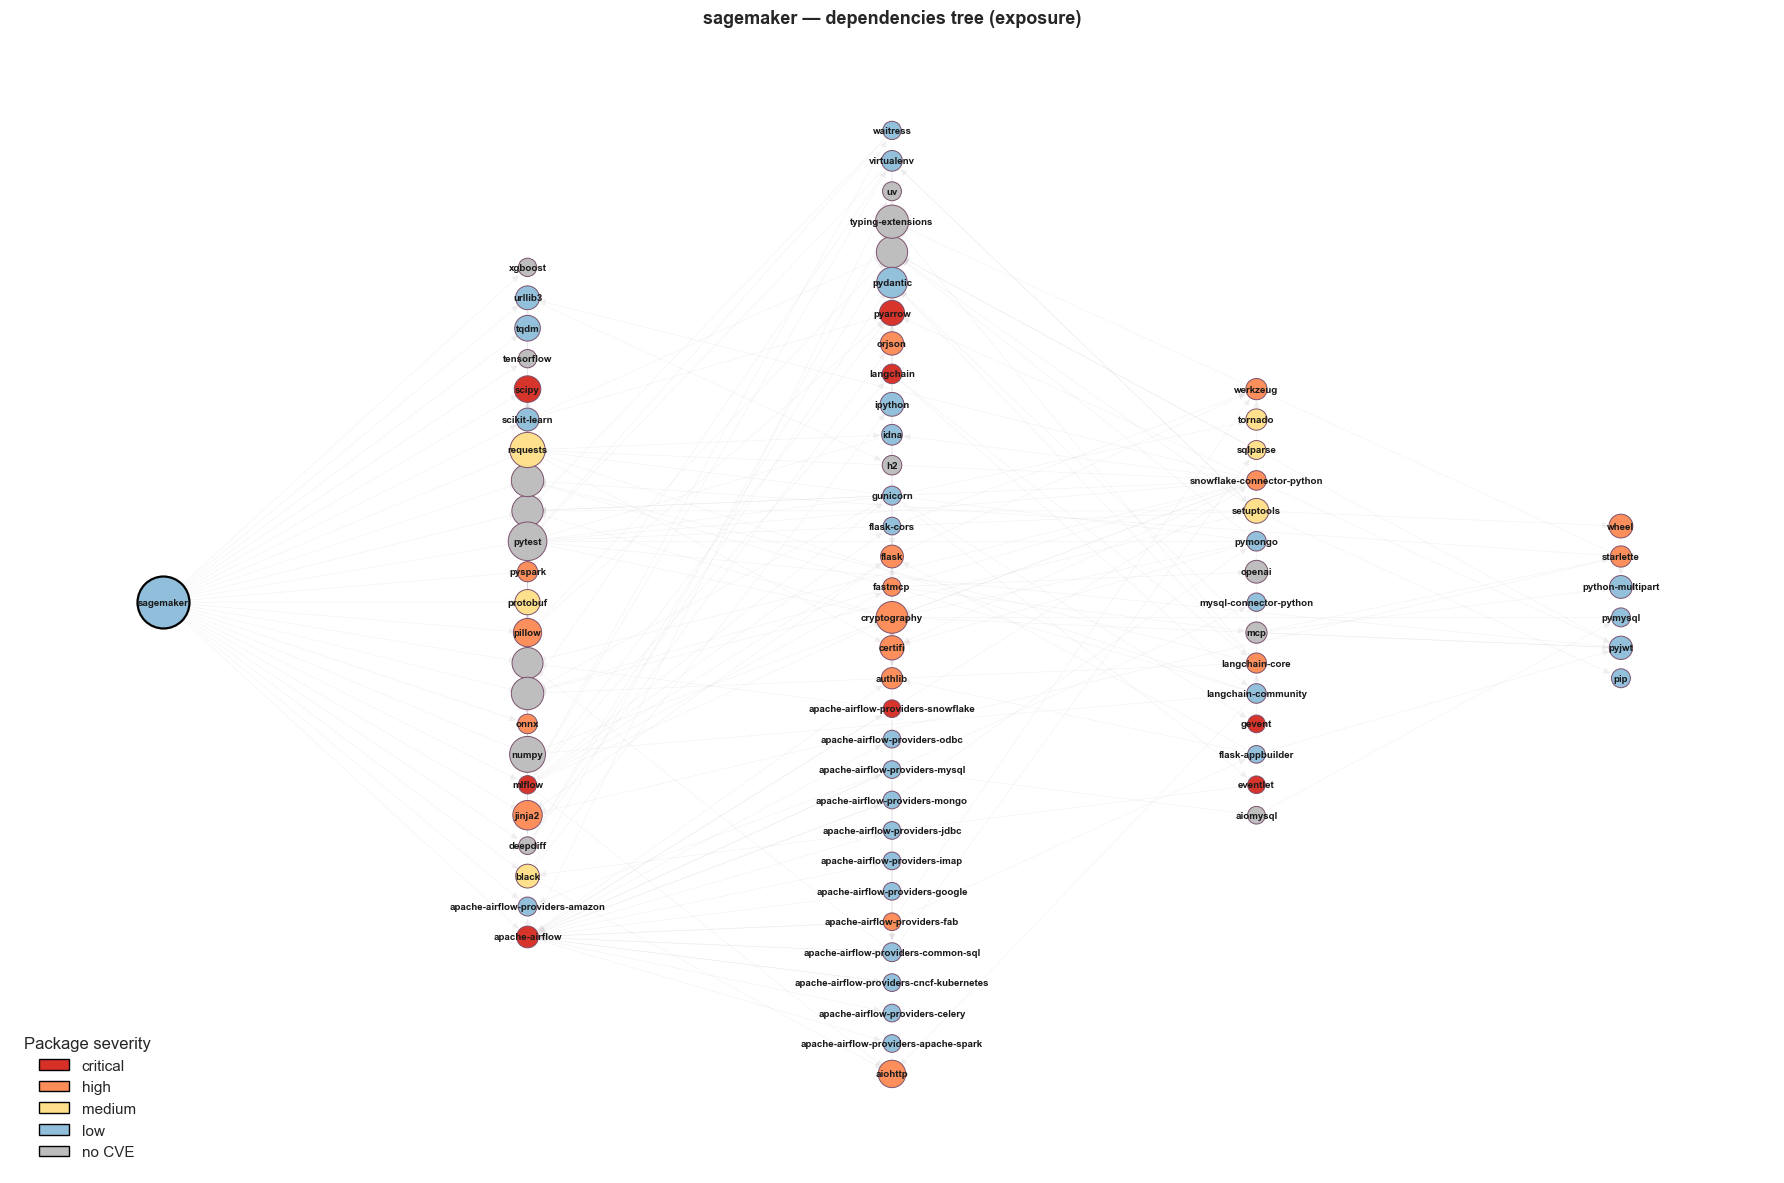

Saved outputs/plots/tree_dependencies_sagemaker.png


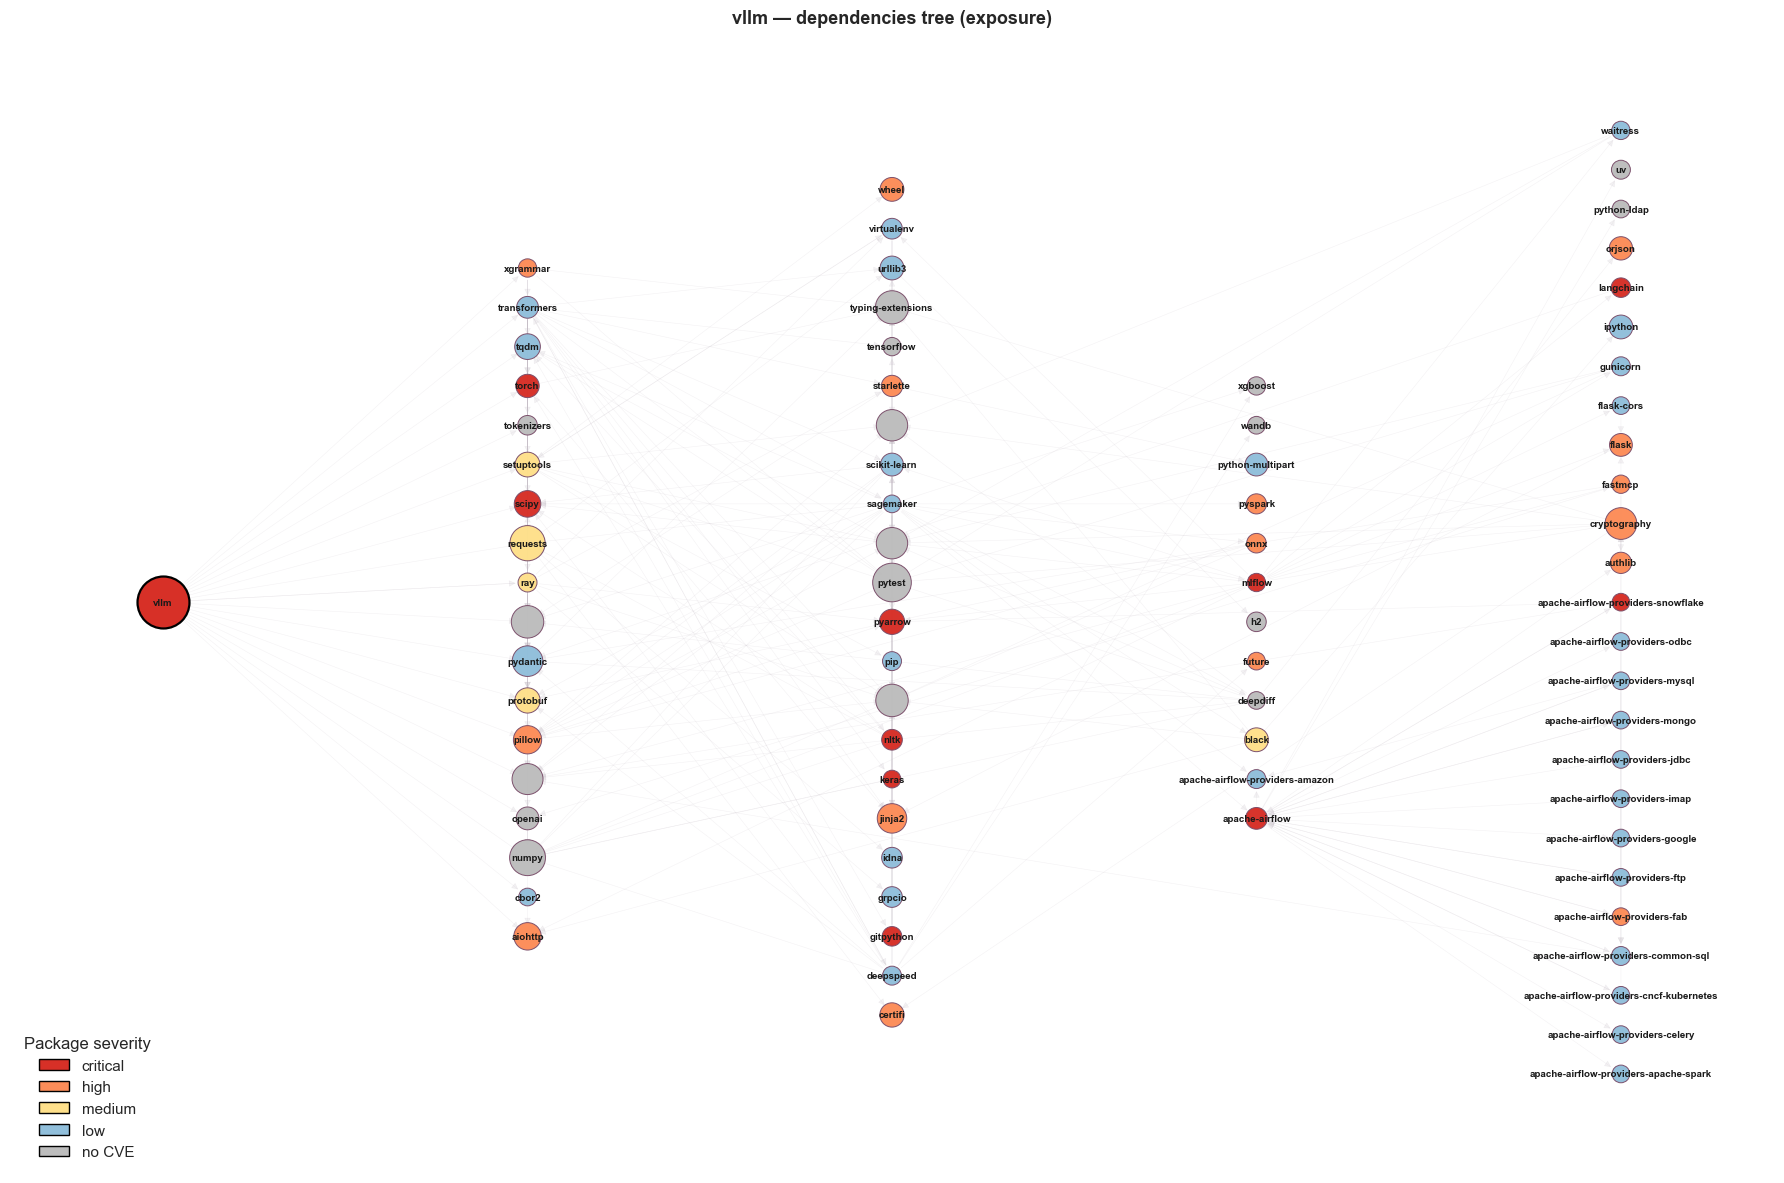

Saved outputs/plots/tree_dependencies_vllm.png


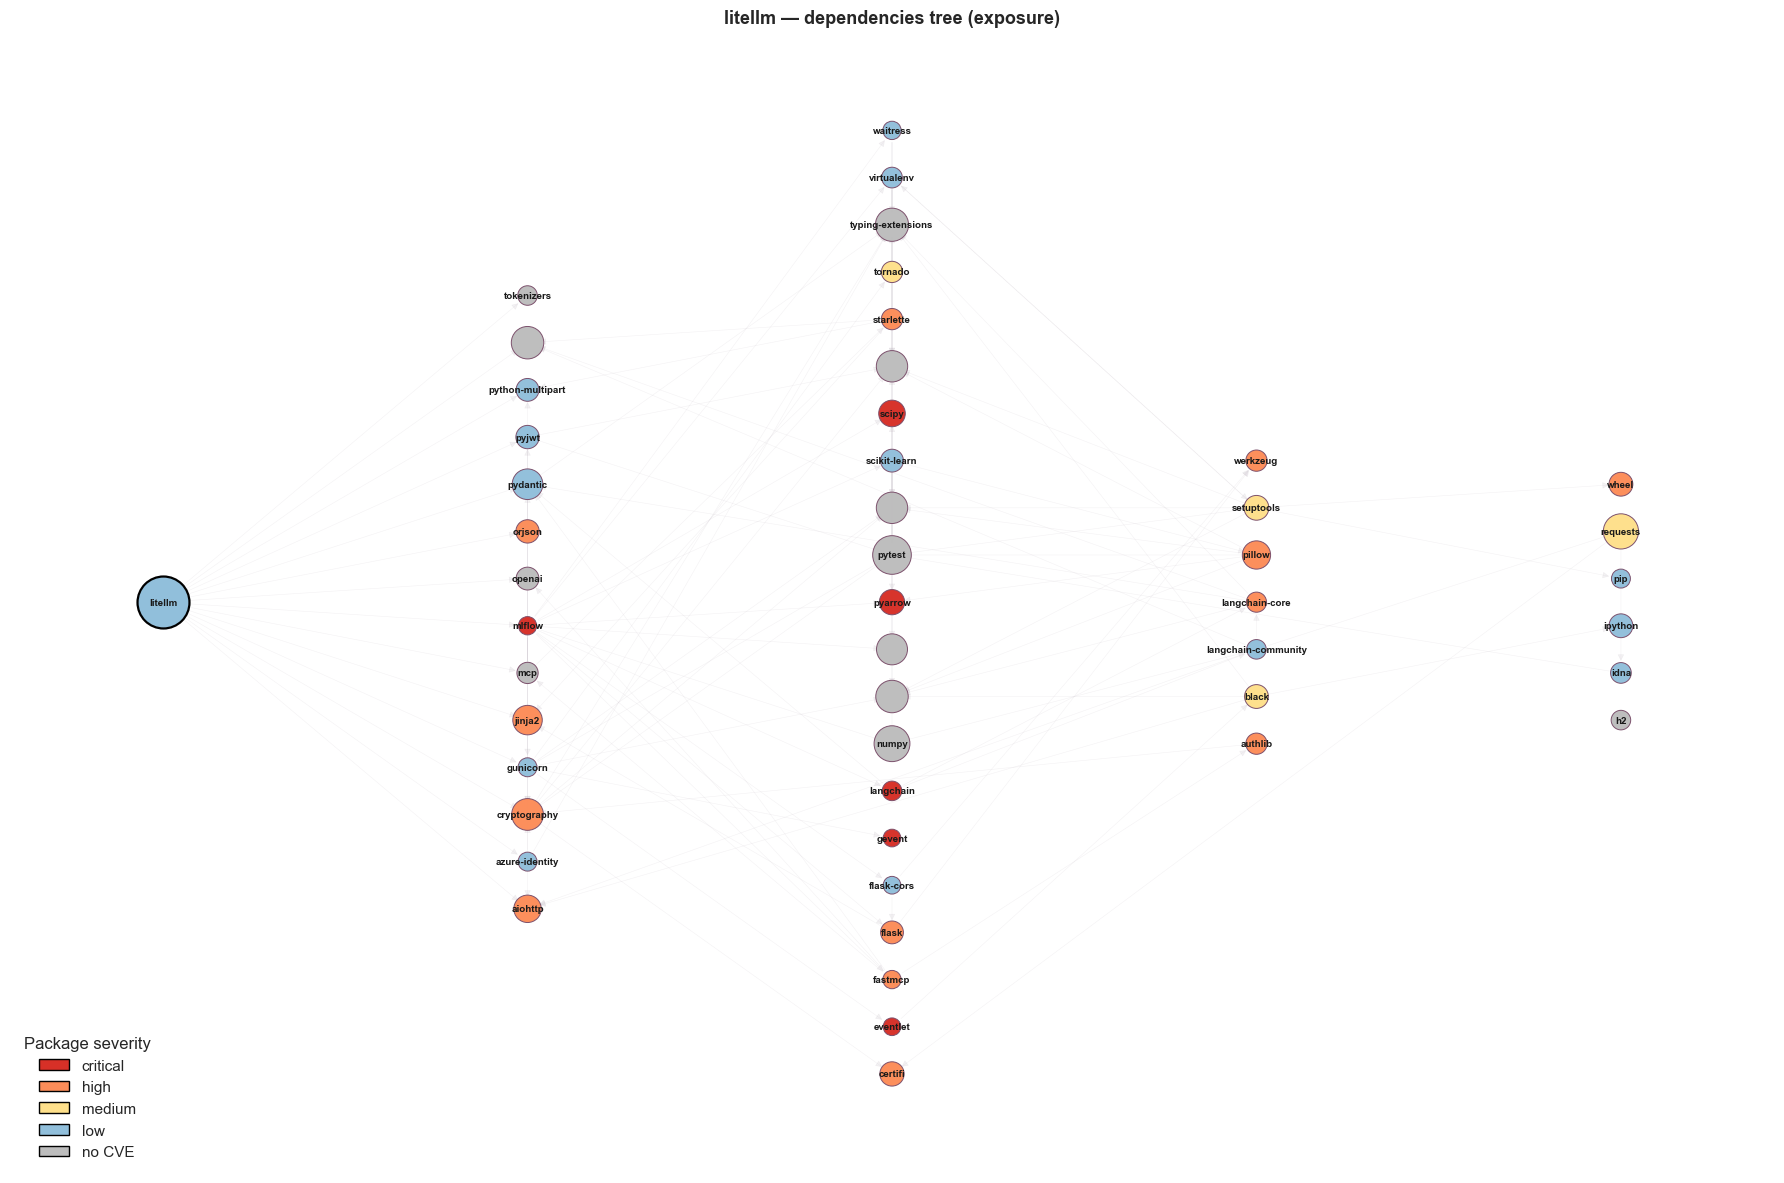

Saved outputs/plots/tree_dependencies_litellm.png


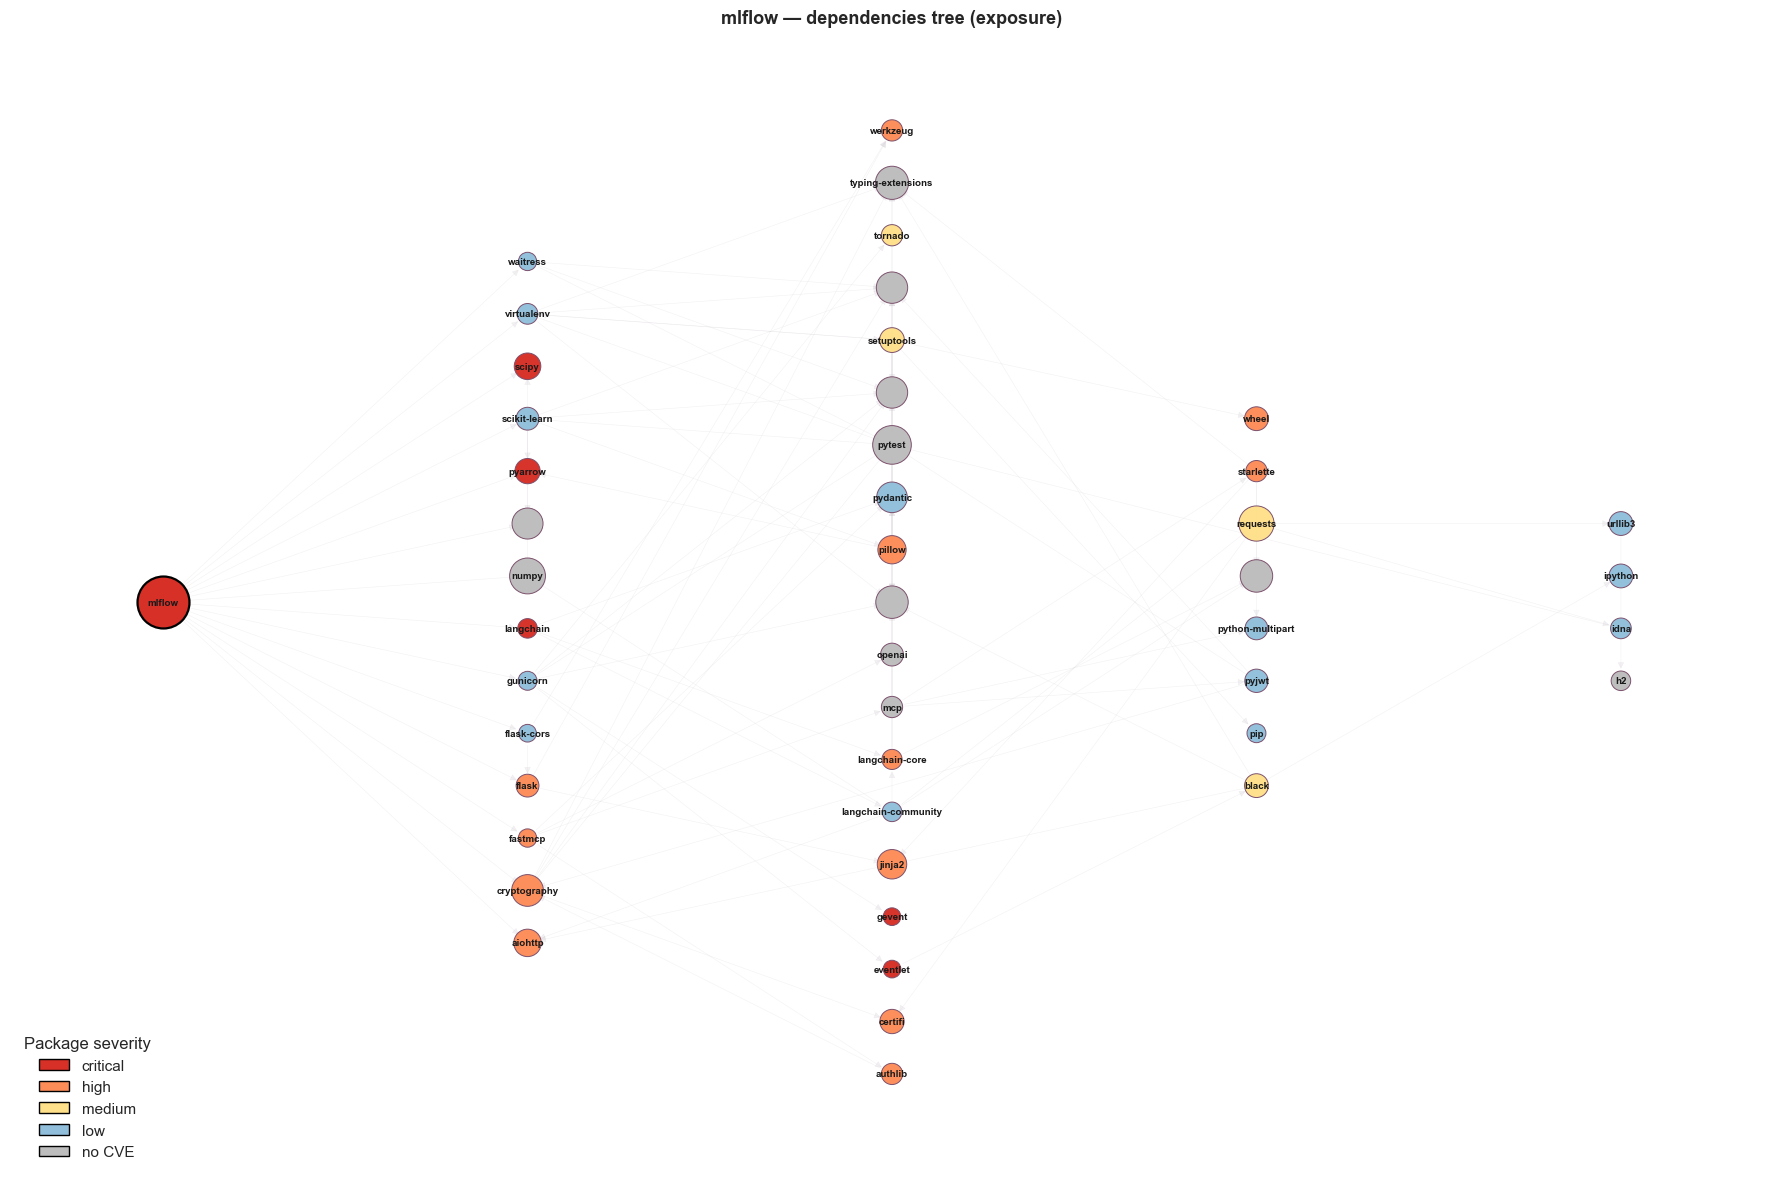

Saved outputs/plots/tree_dependencies_mlflow.png


In [19]:
# Hierarchical dependency trees for top AI libraries (dependents vs dependencies)
#    (versão enxuta – só CVE/AI/hubs e limite de nós por camada)

import math
from collections import deque
import os
from matplotlib.patches import Patch


# ---------- severidade global por pacote (pior severidade no período) ----------

sev_rank_global = {"low": 1, "medium": 2, "moderate": 2, "high": 3, "critical": 4}
sev_label_global = {1: "low", 2: "medium", 3: "high", 4: "critical"}

if "severity" in timeline.columns:
    tmp = timeline.copy()
    tmp["sev_r"] = (
        tmp["severity"].astype(str).str.lower()
        .map(sev_rank_global).fillna(0).astype(int)
    )
    best = tmp.groupby("package")["sev_r"].max()
    pkg_sev = {
        pkg: sev_label_global.get(val, "unknown")
        for pkg, val in best.items()
    }
else:
    pkg_sev = {}

color_map = {
    "critical": "#d73027",
    "high":     "#fc8d59",
    "medium":   "#fee08b",
    "low":      "#91bfdb",
    "unknown":  "#bdbdbd",
}
sev_alias = {"moderate": "medium"}

def sev_color(pkg: str) -> str:
    s = str(pkg_sev.get(str(pkg).lower(), "unknown")).lower()
    s = sev_alias.get(s, s)
    return color_map.get(s, color_map["unknown"])

# conjunto de pacotes com CVE (para filtrar nós interessantes)
PKGS_WITH_CVE = set(timeline["package"].unique())

# ---------- Layout: layered (x = profundidade) ----------

def layered_positions(layers, x_gap: float = 1.0, y_gap: float = 1.0):
    pos = {}
    for depth, nodes in enumerate(layers):
        if not nodes:
            continue
        y_start = -(len(nodes) - 1) * y_gap / 2.0
        for i, n in enumerate(sorted(nodes)):
            pos[n] = (depth * x_gap, y_start + i * y_gap)
    return pos

# ---------- BFS layers (successors = dependencies; predecessors = dependents) ----------

def bfs_layers(G: nx.DiGraph, root: str, direction: str,
               max_hops: int, max_nodes: int):
    assert direction in ("successors", "predecessors")
    visited = {root: 0}
    q = deque([root])

    while q and len(visited) < max_nodes:
        u = q.popleft()
        d = visited[u]
        if d >= max_hops:
            continue
        neigh = G.successors(u) if direction == "successors" else G.predecessors(u)
        for v in neigh:
            if v not in visited:
                visited[v] = d + 1
                q.append(v)
                if len(visited) >= max_nodes:
                    break

    max_d = max(visited.values()) if visited else 0
    layers = [[] for _ in range(max_d + 1)]
    for n, depth in visited.items():
        layers[depth].append(n)
    return layers

# ---------- filtro de camadas para deixar o gráfico enxuto ----------

def filter_layers_for_plot(layers,
                           max_nodes_total: int = 250,
                           max_per_layer: int = 35,
                           min_in_degree_hub: int = 30):
    """
    Mantém:
      - raiz (camada 0 sempre inteira)
      - nós que:
          * têm CVE, ou
          * são AI_LIBS, ou
          * têm in-degree >= min_in_degree_hub (hubs estruturais)
    Limita cada camada a no máximo max_per_layer nós
    e corta total se passar de max_nodes_total.
    """
    filtered = []
    total = 0

    for depth, layer in enumerate(layers):
        if depth == 0:
            # sempre mantém raiz / camada 0
            keep = list(layer)
        else:
            keep = []
            for n in layer:
                name_l = str(n).lower()
                if (name_l in PKGS_WITH_CVE) or (name_l in AI_SET) or \
                   (DG_all.in_degree(n) >= min_in_degree_hub):
                    keep.append(n)

        # ordena por in-degree (hubs primeiro)
        keep = sorted(keep, key=lambda x: DG_all.in_degree(x), reverse=True)

        # limita número por camada
        if len(keep) > max_per_layer:
            keep = keep[:max_per_layer]

        if keep:
            filtered.append(keep)
            total += len(keep)

        if total >= max_nodes_total:
            break  # não adiciona mais camadas

    return filtered

# ---------- Desenhar árvore (genérico para dependents/dependencies) ----------

def draw_tree_generic(root: str, layers, direction: str,
                      out_png: str, title: str):
    """
    direction:
      - 'predecessors'  → dependents (impacto)
      - 'successors'    → dependencies (exposição)
    """
    # aplica filtro antes de desenhar
    layers = filter_layers_for_plot(
        layers,
        max_nodes_total=230,
        max_per_layer=32,
        min_in_degree_hub=25
    )

    nodes = [n for layer in layers for n in layer]
    H_sub = DG_all.subgraph(nodes).copy()

    pos = layered_positions(layers, x_gap=1.8, y_gap=0.7)

    # para árvores de dependents (predecessors) pode ficar mais bonito invertido
    right_to_left = (direction == "predecessors")
    if right_to_left:
        pos = {n: (-x, y) for n, (x, y) in pos.items()}

    fig, ax = plt.subplots(1, 1, figsize=(18, 12))

    # arestas
    edges = [(u, v) for u, v in H_sub.edges() if u in pos and v in pos]
    nx.draw_networkx_edges(
        H_sub, pos, edgelist=edges,
        width=0.4, alpha=0.18, edge_color="#c0b7c1", ax=ax
    )

    # nós (tamanho = in-degree; cor = severidade)
    sizes = []
    colors = []
    for n in H_sub.nodes():
        indeg = max(1, DG_all.in_degree(n))
        sizes.append(min(900, 150 + indeg * 12))
        colors.append(sev_color(n))

    nx.draw_networkx_nodes(
        H_sub, pos,
        node_size=sizes,
        node_color=colors,
        edgecolors="#7a4e6a",
        linewidths=0.7,
        alpha=0.98,
        ax=ax
    )

    # labels – só nos nós "interessantes" (AI ou com CVE / hubs)
    labels = {}
    for n in H_sub.nodes():
        name_l = str(n).lower()
        if (name_l in PKGS_WITH_CVE) or (name_l in AI_SET) or \
           (DG_all.in_degree(n) >= 35) or (n == root):
            labels[n] = n

    nx.draw_networkx_labels(
        H_sub, pos,
        labels=labels,
        font_size=7,
        font_weight="bold",
        ax=ax
    )

    # destacar raiz
    if root in pos:
        nx.draw_networkx_nodes(
            H_sub, pos,
            nodelist=[root],
            node_size=1400,
            node_color=sev_color(root),
            edgecolors="black",
            linewidths=1.6,
            ax=ax
        )

    # legenda de severidade
    sev_handles = [
        Patch(facecolor=color_map["critical"], edgecolor="black", label="critical"),
        Patch(facecolor=color_map["high"],     edgecolor="black", label="high"),
        Patch(facecolor=color_map["medium"],   edgecolor="black", label="medium"),
        Patch(facecolor=color_map["low"],      edgecolor="black", label="low"),
        Patch(facecolor=color_map["unknown"],  edgecolor="black", label="no CVE"),
    ]
    ax.legend(
        handles=sev_handles,
        title="Package severity",
        frameon=False,
        loc="lower left"
    )

    ax.set_title(title, fontsize=13, fontweight="bold")
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    plt.show()
    print("Saved", out_png)

# ---------- Escolher seeds de IA por in_degree e out_degree ----------

AI_IN_DEGREE_TOP_K  = 5   # árvores de dependents (impacto)
AI_OUT_DEGREE_TOP_K = 5   # árvores de dependencies (exposição)
MAX_HOPS  = 4
MAX_NODES = 800

ai_nodes_all = [p.lower() for p in AI_LIBS if p.lower() in DG_all]

indeg_ai = sorted(
    [(n, DG_all.in_degree(n)) for n in ai_nodes_all],
    key=lambda x: x[1],
    reverse=True
)[:AI_IN_DEGREE_TOP_K]

outdeg_ai = sorted(
    [(n, DG_all.out_degree(n)) for n in ai_nodes_all],
    key=lambda x: x[1],
    reverse=True
)[:AI_OUT_DEGREE_TOP_K]

os.makedirs("outputs/plots", exist_ok=True)

# árvores de dependents (impacto)
for pkg, _ in indeg_ai:
    layers = bfs_layers(
        DG_all, pkg, direction="predecessors",
        max_hops=MAX_HOPS, max_nodes=MAX_NODES
    )
    title = f"{pkg} — dependents tree (influence)"
    out   = f"outputs/plots/tree_dependents_{pkg}.png"
    draw_tree_generic(pkg, layers, "predecessors", out, title)

# árvores de dependencies (exposição)
for pkg, _ in outdeg_ai:
    layers = bfs_layers(
        DG_all, pkg, direction="successors",
        max_hops=MAX_HOPS, max_nodes=MAX_NODES
    )
    title = f"{pkg} — dependencies tree (exposure)"
    out   = f"outputs/plots/tree_dependencies_{pkg}.png"
    draw_tree_generic(pkg, layers, "successors", out, title)


In [22]:
lam = beta / mu

print("===== NETWORK EPIDEMICS REPORT – AI DEPENDENCIES (SIS) =====")
print(f"Nodes (H): {H.number_of_nodes()}  Edges (H): {H.number_of_edges()}")
print(f"<k>  = {k_arr.mean():.2f}")
print(f"<k²> = {(k_arr**2).mean():.2f}")
print(f"Exponent α ≈ {alpha:.2f}")
print(f"Epidemic threshold λ_c ≈ {lambda_c:.4f}")
print(f"β={beta}, μ={mu}, λ=β/μ={lam:.3f}, λ/λ_c ≈ {lam / lambda_c:.2f}")
print(f"Prevalência estacionária ρ₀ (sem imunização, dirigido) ≈ {rho0:.3f}")
print("\nTop 10 hubs (degree):")
print(centrality_df.sort_values("degree", ascending=False)
      .head(10)[["package","degree","in_degree","out_degree","betweenness","cluster"]])
print("\nEfeito médio da imunização (ρ_g/ρ_0):")
for g, r_u, r_t in zip(g_values, rho_uniform, rho_target):
    print(f"g={g:.2f}: uniform={r_u:.3f}, targeted={r_t:.3f}")


===== NETWORK EPIDEMICS REPORT – AI DEPENDENCIES (SIS) =====
Nodes (H): 427  Edges (H): 1272
<k>  = 5.96
<k²> = 155.04
Exponent α ≈ 1.60
Epidemic threshold λ_c ≈ 0.0384
β=0.25, μ=0.1, λ=β/μ=2.500, λ/λ_c ≈ 65.06
Prevalência estacionária ρ₀ (sem imunização, dirigido) ≈ 0.783

Top 10 hubs (degree):
          package  degree  in_degree  out_degree  betweenness  cluster
136  transformers     106          8          99     0.263782        4
370     sagemaker      78          1          77     0.168927        2
218          vllm      69          1          69     0.132432        5
335         feast      59          0          59     0.055090        2
140       litellm      49          3          46     0.076706        3
311        mlflow      45          2          43     0.108352        7
91     open-webui      44          0          44     0.047250        3
225        pillow      44         22          22     0.086185        2
36   scikit-learn      43         10          33     0.085279   